# Import Important Libraries

In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna
from tqdm.notebook import tqdm
import shap
import pickle

import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [ ]:
train = pd.read_csv('/kaggle/input/dataset-find-it-2025/train.csv') # change to local directory if needed
label = pd.read_csv('/kaggle/input/dataset-find-it-2025/target.csv') # change to local directory if needed
test = pd.read_csv('/kaggle/input/dataset-find-it-2025/test.csv') # change to local directory if needed
test = test.drop('ID', axis=1)
submission_format = pd.read_csv('/kaggle/input/dataset-find-it-2025/submission_format.csv') # change to local directory if needed
df = pd.concat([train, test], axis=0)
train_label = pd.concat([train, label], axis=1)

# Dataset Understanding

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   developerCountry                 10000 non-null  object 
 1   countryCode                      9907 non-null   object 
 2   userRatingCount                  10000 non-null  int64  
 3   primaryGenreName                 10000 non-null  object 
 4   downloads                        6970 non-null   object 
 5   deviceType                       10000 non-null  object 
 6   hasPrivacyLink                   8934 non-null   object 
 7   hasTermsOfServiceLink            3404 non-null   object 
 8   hasTermsOfServiceLinkRating      3404 non-null   object 
 9   isCorporateEmailScore            8432 non-null   float64
 10  adSpent                          1895 non-null   float64
 11  appAge                           9933 non-null   float64
 12  averageUserRating       

In [240]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   developerCountry                 3000 non-null   object 
 1   countryCode                      2971 non-null   object 
 2   userRatingCount                  3000 non-null   int64  
 3   primaryGenreName                 3000 non-null   object 
 4   downloads                        2119 non-null   object 
 5   deviceType                       3000 non-null   object 
 6   hasPrivacyLink                   2684 non-null   object 
 7   hasTermsOfServiceLink            1039 non-null   object 
 8   hasTermsOfServiceLinkRating      1039 non-null   object 
 9   isCorporateEmailScore            2560 non-null   float64
 10  adSpent                          574 non-null    float64
 11  appAge                           2983 non-null   float64
 12  averageUserRating   

In [241]:
train.shape

(7000, 16)

In [242]:
test.shape

(3000, 16)

In [243]:
train.head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating
0,NORWAY,RO,127731,Sports,NaN,smartphone,True,True,low,99.0,14.017220,160.400000,4.0,medium,low,low
1,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Medical,50 - 100,GLOBAL,True,NaN,NaN,99.0,NaN,17.500000,0.0,NaN,low,low
2,UNITED ARAB EMIRATES,CZ,51143,Games,50000000 - 100000000,GLOBAL,True,True,low,0.0,31.883163,30.766667,4.0,NaN,low,low
3,GERMANY,GLOBAL,1074,Games,NaN,GLOBAL,True,NaN,NaN,99.0,NaN,71.533333,4.0,NaN,low,low
4,CANNOT IDENTIFY COUNTRY,GLOBAL,17,Tools,1000 - 5000,GLOBAL,True,NaN,NaN,99.0,NaN,52.400000,4.0,NaN,low,low


In [244]:
test.head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating
0,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,2,Medical,NaN,GLOBAL,True,NaN,NaN,NaN,NaN,81.600000,5.0,NaN,low,low
1,ICELAND,EMEA,0,Games,5000 - 10000,GLOBAL,True,True,low,0.0,0.027742,24.700000,0.0,NaN,low,low
2,UNITED STATES,RU,13059,Games,NaN,smartphone,True,False,high,99.0,9.249056,40.300000,4.0,NaN,low,low
3,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Games,NaN,GLOBAL,True,False,high,NaN,NaN,39.233333,0.0,NaN,medium,low
4,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Shopping,NaN,GLOBAL,NaN,NaN,NaN,NaN,NaN,65.533333,0.0,NaN,low,low


In [245]:
train.describe()

,userRatingCount,isCorporateEmailScore,adSpent,appAge,averageUserRating
count,7.000000e+03,5872.000000,1.321000e+03,6950.000000,5768.000000
mean,3.256274e+04,45.740293,3.977563e+03,57.093060,2.482490
std,5.501431e+05,49.361215,9.219919e+04,37.169895,1.905712
min,0.000000e+00,0.000000,7.038525e-03,0.533333,0.000000
25%,0.000000e+00,0.000000,1.086920e+00,27.533333,0.000000
50%,1.000000e+00,0.000000,7.945580e+00,52.866667,3.000000
75%,8.800000e+01,99.000000,4.908375e+01,80.000000,4.000000
max,3.854334e+07,99.000000,3.143906e+06,196.466667,5.000000


In [246]:
test.describe()

,userRatingCount,isCorporateEmailScore,adSpent,appAge,averageUserRating
count,3.000000e+03,2560.000000,574.000000,2983.000000,2486.000000
mean,3.576905e+04,46.444922,286.612276,56.044396,2.490748
std,4.455556e+05,49.415285,1890.997697,36.417410,1.896230
min,0.000000e+00,0.000000,0.007450,-1.200000,0.000000
25%,0.000000e+00,0.000000,1.121507,26.933333,0.000000
50%,1.000000e+00,0.000000,7.186537,51.933333,3.000000
75%,8.250000e+01,99.000000,44.878463,77.750000,4.000000
max,1.319941e+07,99.000000,37542.779693,194.466667,5.000000


# EDA

In [247]:
numerical = df.select_dtypes(exclude='object').columns.tolist()
categorical = df.select_dtypes(include='object').columns.tolist()

## Categorical Unique Values

In [248]:
for col in categorical:
    print(f"==== {col} ====")
    print(df[col].unique())
    print()

==== developerCountry ====
['NORWAY' 'ADDRESS NOT LISTED IN PLAYSTORE' 'UNITED ARAB EMIRATES'
 'GERMANY' 'CANNOT IDENTIFY COUNTRY' 'FINLAND' 'SINGAPORE' 'UNITED STATES'
 'REPUBLIC OF KOREA' 'MONGOLIA' 'PAKISTAN' 'VIET NAM' 'OMAN' 'FRANCE'
 'INDIA' 'CHINA' 'NETHERLANDS' 'RUSSIAN FEDERATION' 'INDONESIA' 'ITALY'
 'UZBEKISTAN' 'UNITED KINGDOM' 'CANADA' 'NEW ZEALAND' 'SRI LANKA'
 'AUSTRALIA' "COTE D'IVOIRE" 'IRELAND' 'KAZAKHSTAN' 'HONG KONG' 'CHILE'
 'BAHRAIN' 'JAPAN' 'SWITZERLAND' 'ISRAEL' 'SPAIN' 'TURKEY' 'ESTONIA'
 'SWEDEN' 'DOMINICAN REPUBLIC' 'AUSTRIA' 'MALAYSIA' 'POLAND' 'CYPRUS'
 'UKRAINE' 'ISLE OF MAN' 'ARGENTINA' 'BANGLADESH' 'ICELAND' 'JORDAN'
 'MOROCCO' 'PERU' 'NIGER' 'BULGARIA' 'ROMANIA' 'SLOVENIA' 'SOUTH AFRICA'
 'KENYA' 'NIGERIA' 'ALBANIA' 'CZECH REPUBLIC' 'SAUDI ARABIA' 'PANAMA'
 'ANDORRA' 'THAILAND' 'MALTA' 'VENEZUELA' 'GREECE' 'YEMEN' 'EGYPT'
 'PHILIPPINES' 'MEXICO' 'BRUNEI DARUSSALAM' 'PORTUGAL'
 'TAIWAN, PROVINCE OF CHINA' 'GEORGIA' 'CAYMAN ISLANDS' 'DENMARK'
 'ZIMBABWE' 

## Categorical Null Values

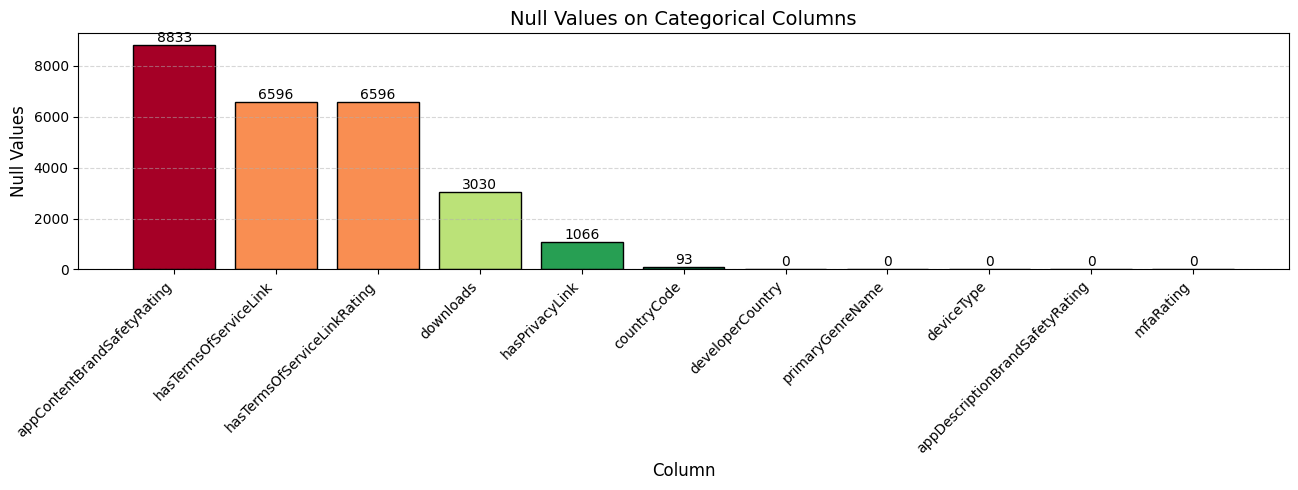

In [249]:
null_cat = df[categorical].isnull().sum()
null_num = df[numerical].isnull().sum()

def plot_null_bar(null_series, title):
    null_sorted = null_series.sort_values(ascending=False)
    colors = sns.color_palette("RdYlGn_r", as_cmap=True)
    
    norm = plt.Normalize(null_sorted.min(), null_sorted.max())
    bar_colors = [colors(norm(val)) for val in null_sorted]

    plt.figure(figsize=(max(8, len(null_sorted)*1.2), 5))
    bars = plt.bar(null_sorted.index, null_sorted.values, color=bar_colors, edgecolor='black')

    plt.title(title, fontsize=14)
    plt.xlabel('Column', fontsize=12)
    plt.ylabel('Null Values', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, int(height),
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_null_bar(null_cat, "Null Values on Categorical Columns")

## Numerical Null Values

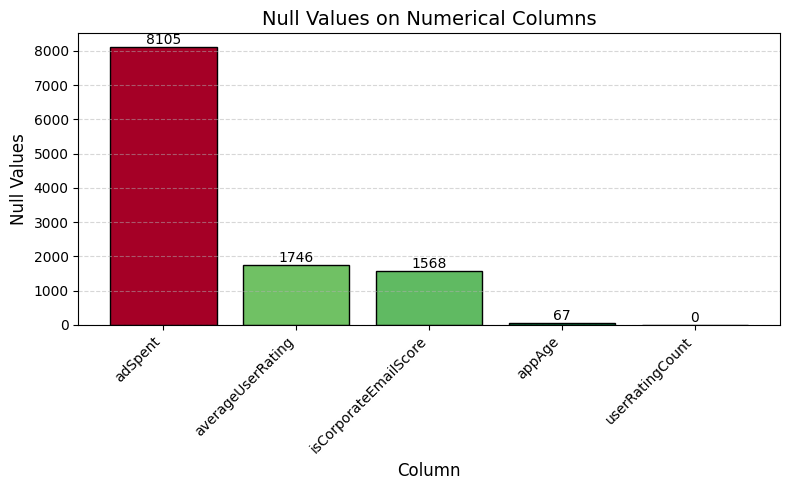

In [250]:
plot_null_bar(null_num, "Null Values on Numerical Columns")

## Categorical Unique Counts

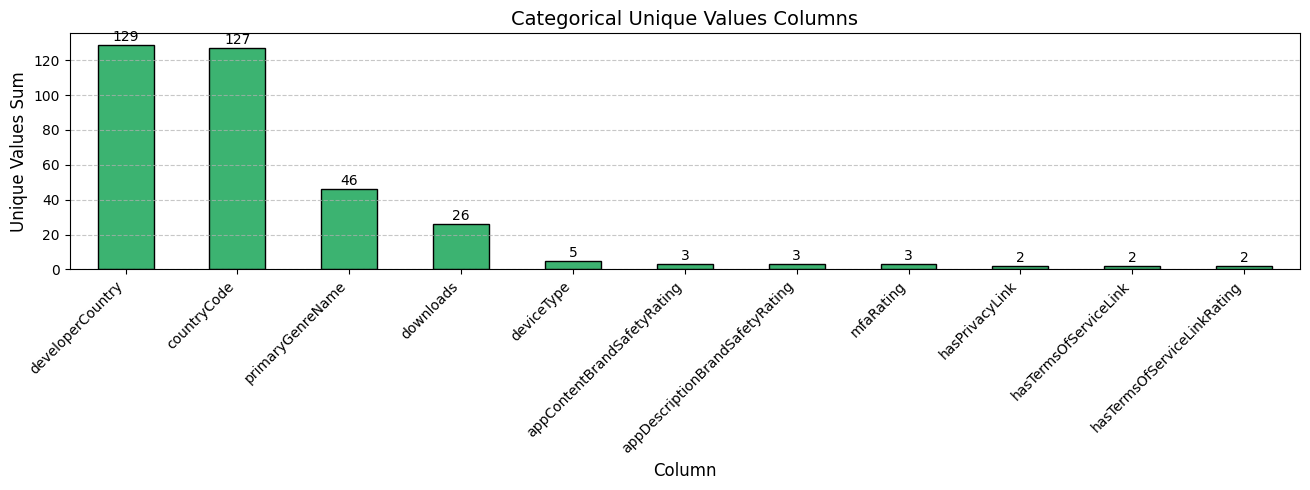

In [251]:
unique_counts = {col: df[col].nunique() for col in categorical}

unique_series = pd.Series(unique_counts).sort_values(ascending=False)

plt.figure(figsize=(max(8, len(unique_series)*1.2), 5))
ax = unique_series.plot(kind='bar', color='mediumseagreen', edgecolor='black')

plt.title('Categorical Unique Values Columns', fontsize=14)
plt.xlabel('Column', fontsize=12)
plt.ylabel('Unique Values Sum', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(unique_series):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Categorical Columns Value Counts

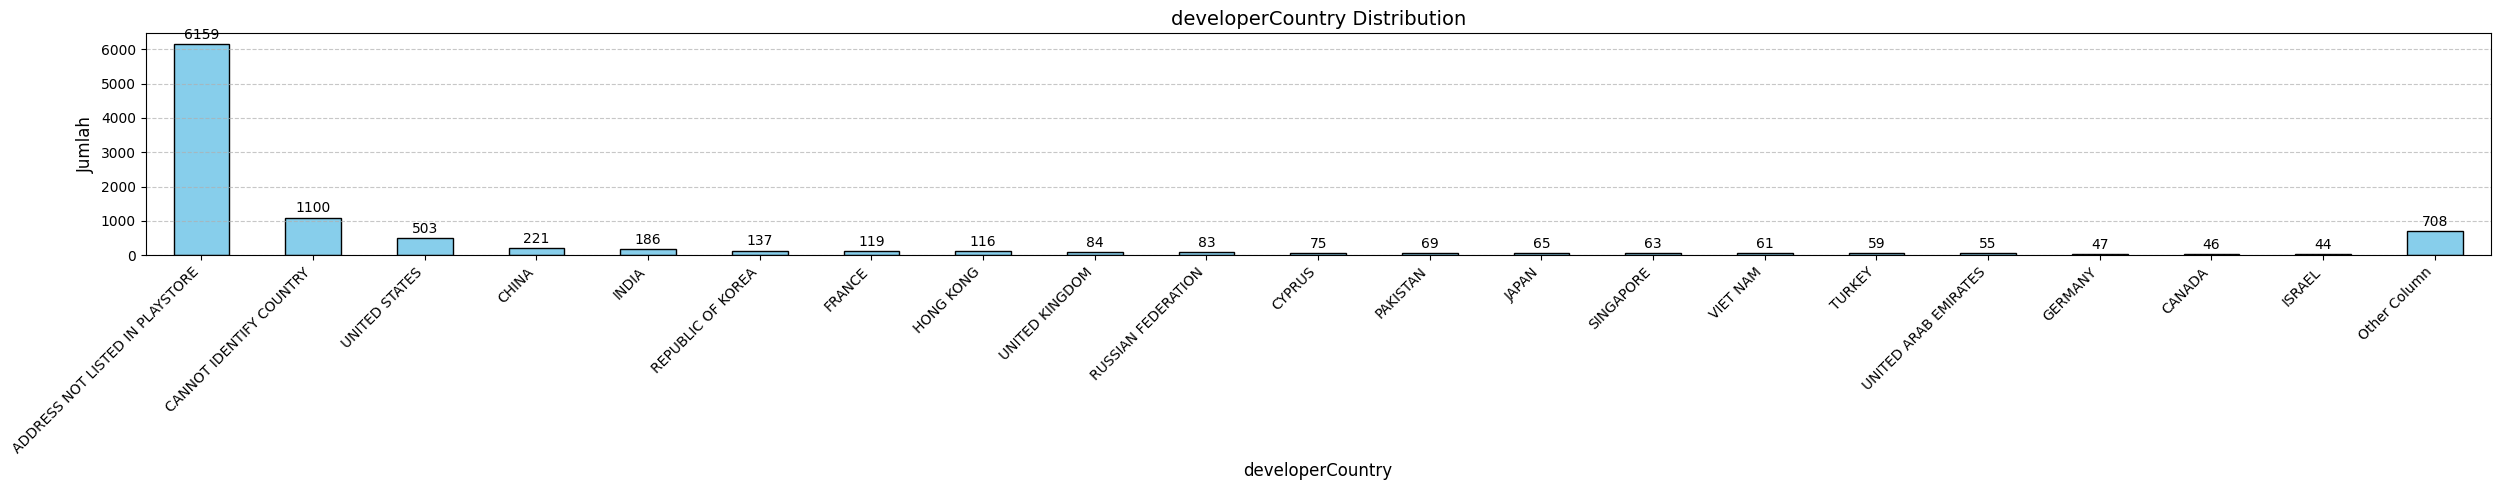

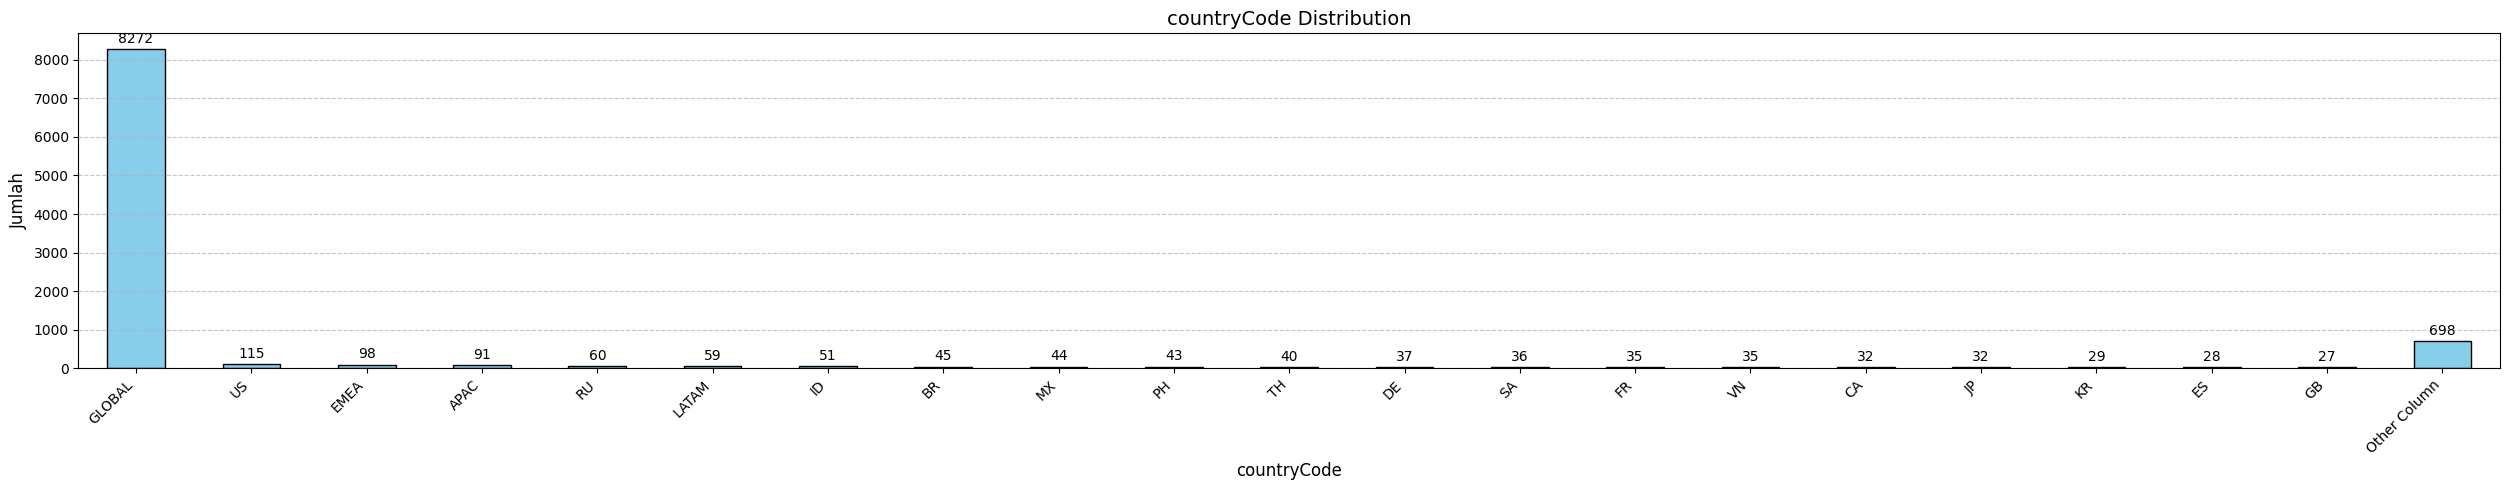

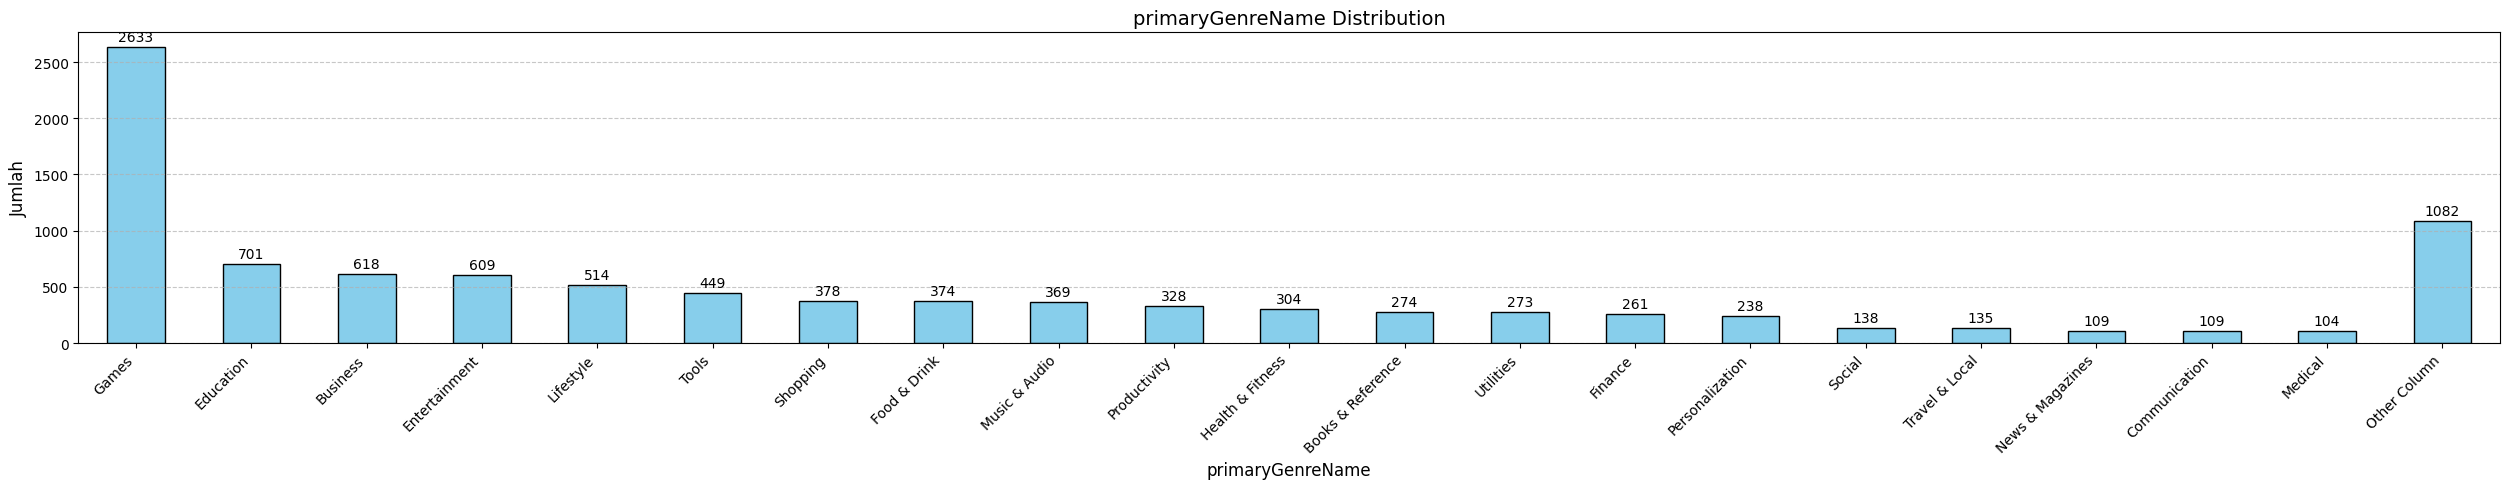

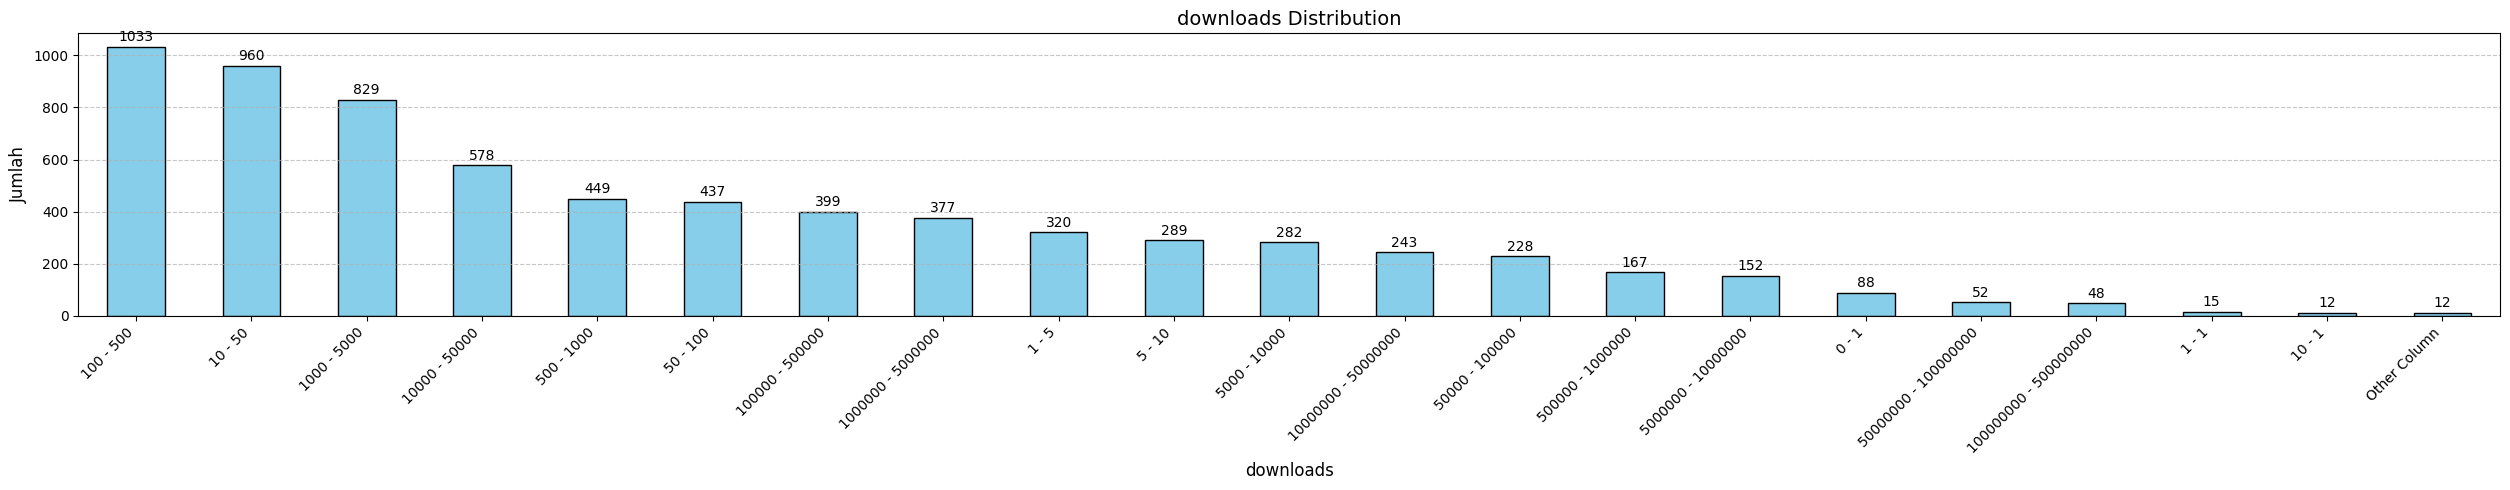

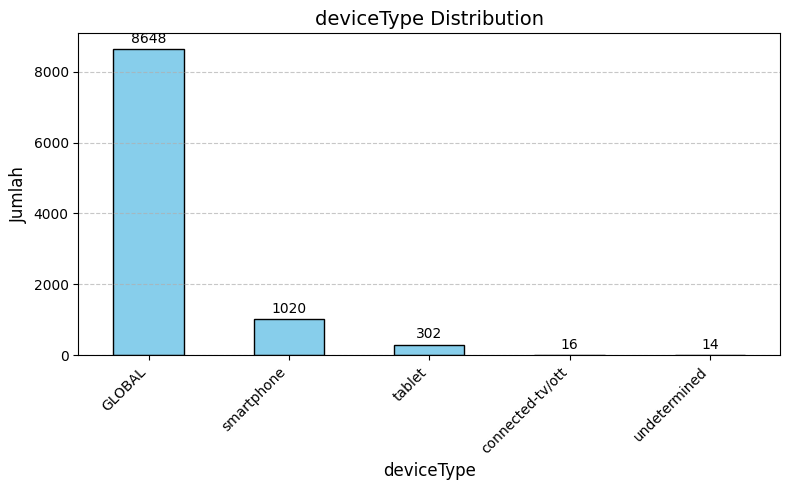

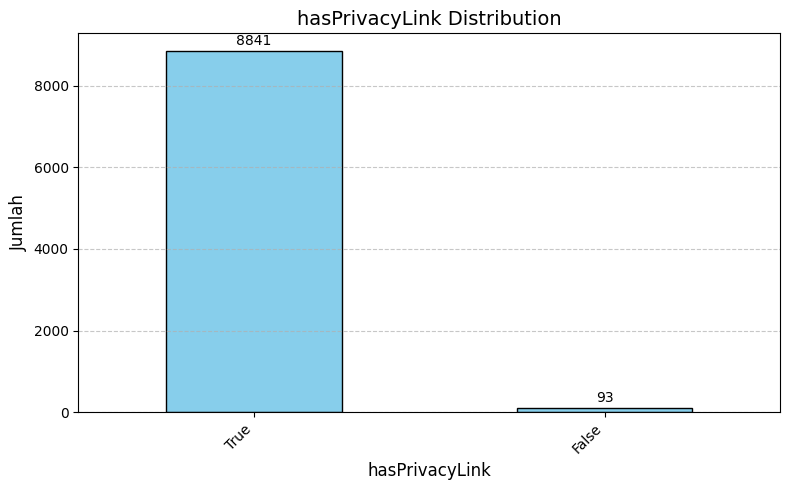

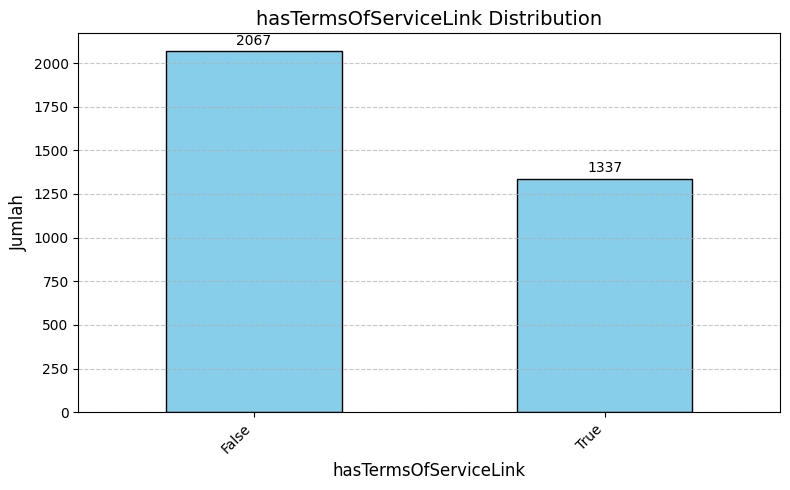

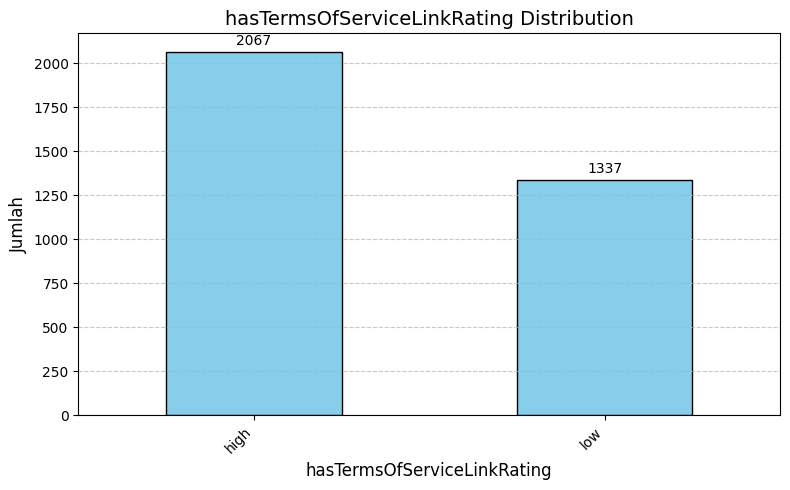

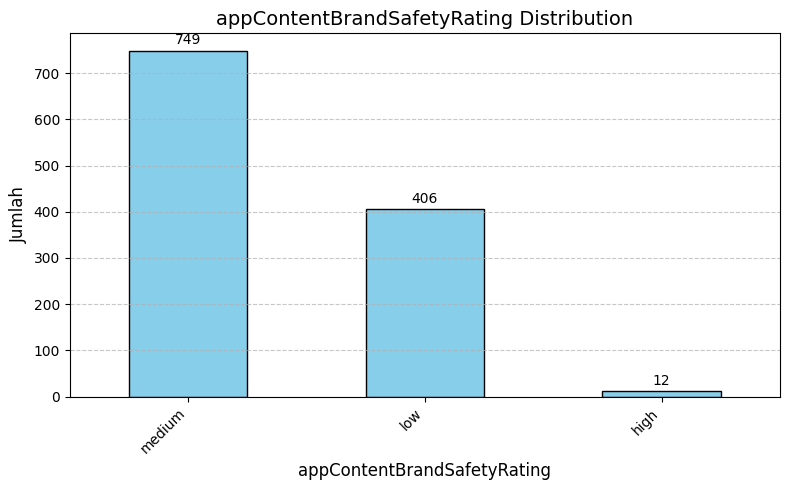

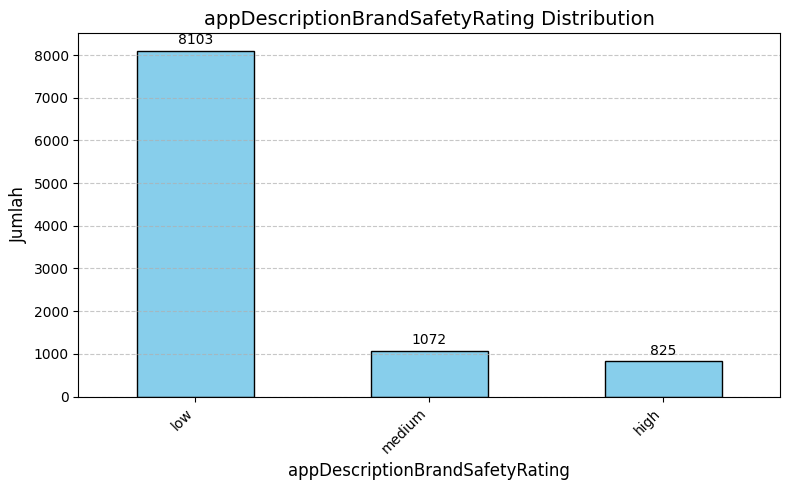

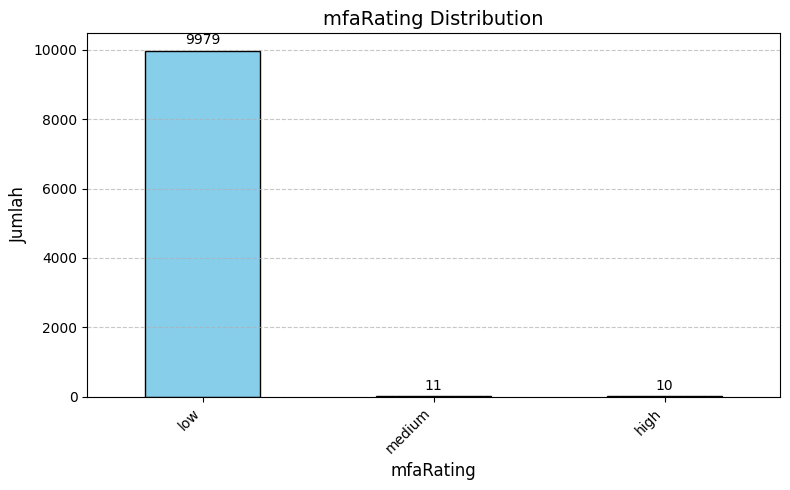

In [252]:
MAX_CATEGORIES = 20

for col in categorical:
    counts = df[col].value_counts()

    if len(counts) > MAX_CATEGORIES:
        top_counts = counts.iloc[:MAX_CATEGORIES]
        others_sum = counts.iloc[MAX_CATEGORIES:].sum()
        top_counts["Other Column"] = others_sum
    else:
        top_counts = counts

    plt.figure(figsize=(max(8, len(top_counts)*1.2), 5))
    ax = top_counts.plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title(f'{col} Distribution', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Jumlah', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for i, value in enumerate(top_counts):
        ax.text(i, value + top_counts.max()*0.01, str(value), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

## Categorical Columns Unique Values

In [253]:
for col in categorical:
    print(7*"=" + col + 7*"")
    print(df[col].unique())
    print()

=======developerCountry
['NORWAY' 'ADDRESS NOT LISTED IN PLAYSTORE' 'UNITED ARAB EMIRATES'
 'GERMANY' 'CANNOT IDENTIFY COUNTRY' 'FINLAND' 'SINGAPORE' 'UNITED STATES'
 'REPUBLIC OF KOREA' 'MONGOLIA' 'PAKISTAN' 'VIET NAM' 'OMAN' 'FRANCE'
 'INDIA' 'CHINA' 'NETHERLANDS' 'RUSSIAN FEDERATION' 'INDONESIA' 'ITALY'
 'UZBEKISTAN' 'UNITED KINGDOM' 'CANADA' 'NEW ZEALAND' 'SRI LANKA'
 'AUSTRALIA' "COTE D'IVOIRE" 'IRELAND' 'KAZAKHSTAN' 'HONG KONG' 'CHILE'
 'BAHRAIN' 'JAPAN' 'SWITZERLAND' 'ISRAEL' 'SPAIN' 'TURKEY' 'ESTONIA'
 'SWEDEN' 'DOMINICAN REPUBLIC' 'AUSTRIA' 'MALAYSIA' 'POLAND' 'CYPRUS'
 'UKRAINE' 'ISLE OF MAN' 'ARGENTINA' 'BANGLADESH' 'ICELAND' 'JORDAN'
 'MOROCCO' 'PERU' 'NIGER' 'BULGARIA' 'ROMANIA' 'SLOVENIA' 'SOUTH AFRICA'
 'KENYA' 'NIGERIA' 'ALBANIA' 'CZECH REPUBLIC' 'SAUDI ARABIA' 'PANAMA'
 'ANDORRA' 'THAILAND' 'MALTA' 'VENEZUELA' 'GREECE' 'YEMEN' 'EGYPT'
 'PHILIPPINES' 'MEXICO' 'BRUNEI DARUSSALAM' 'PORTUGAL'
 'TAIWAN, PROVINCE OF CHINA' 'GEORGIA' 'CAYMAN ISLANDS' 'DENMARK'
 'ZIMBABWE' 'GH

## Violin Plot of Numerical Columns

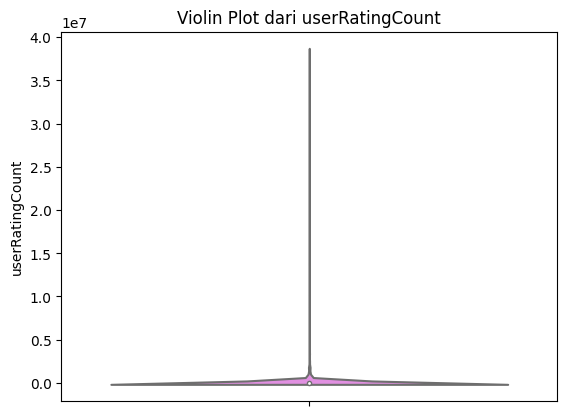

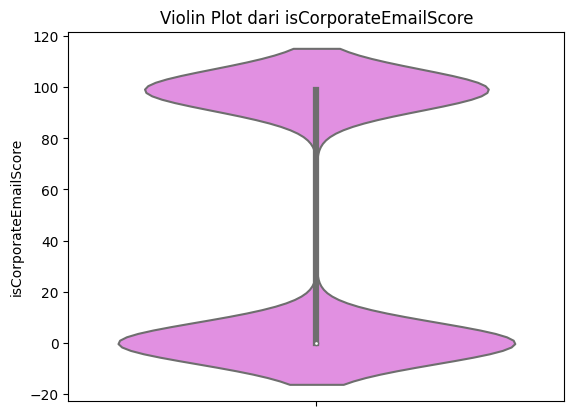

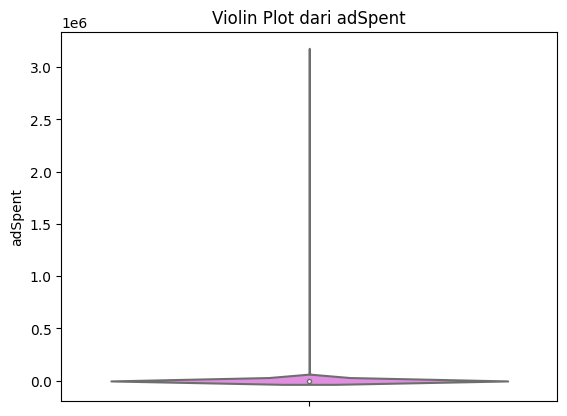

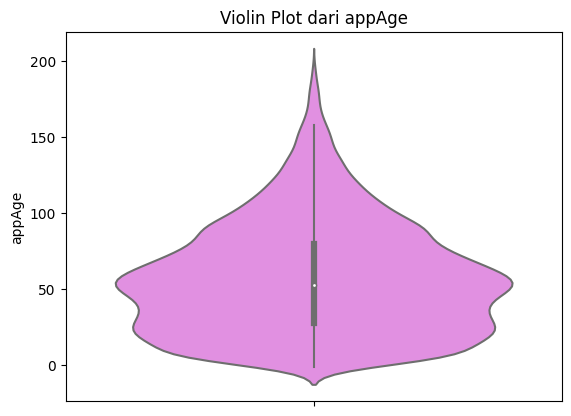

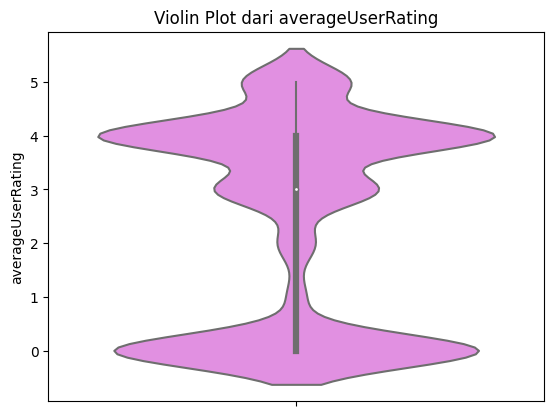

In [254]:
for col in numerical:
    sns.violinplot(y=df[col], color='violet')
    plt.title(f'Violin Plot dari {col}')
    plt.show()

## Boxplot of Numerical Columns

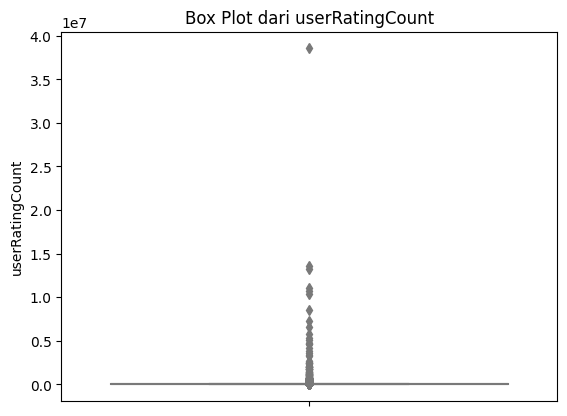

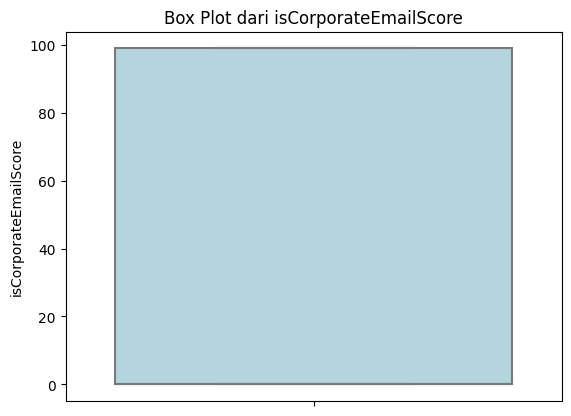

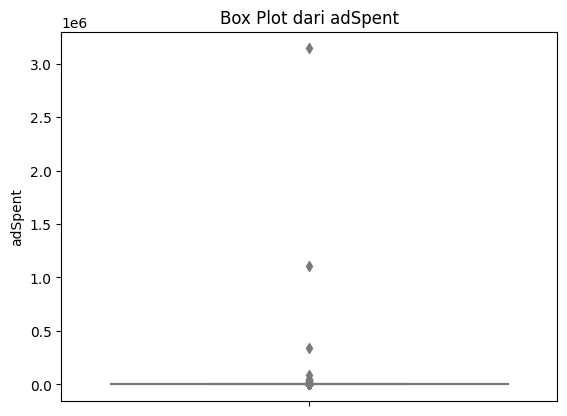

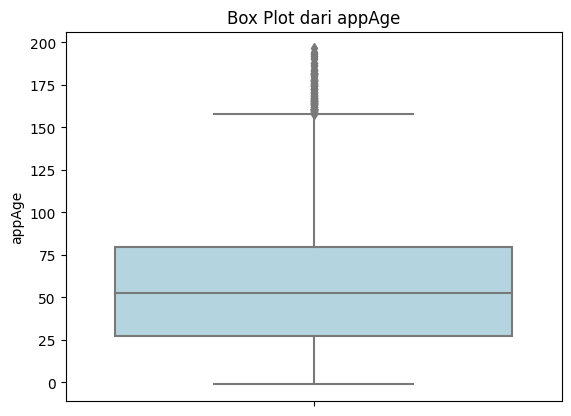

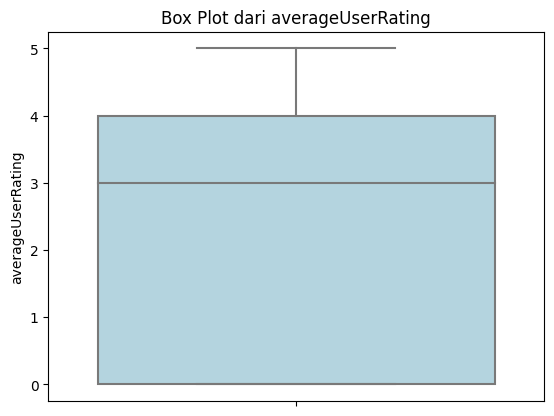

In [255]:
for col in numerical:
    sns.boxplot(y=df[col], color='lightblue')  
    plt.title(f'Box Plot dari {col}')
    plt.show()

## Pairplot with coppaRisk Hue

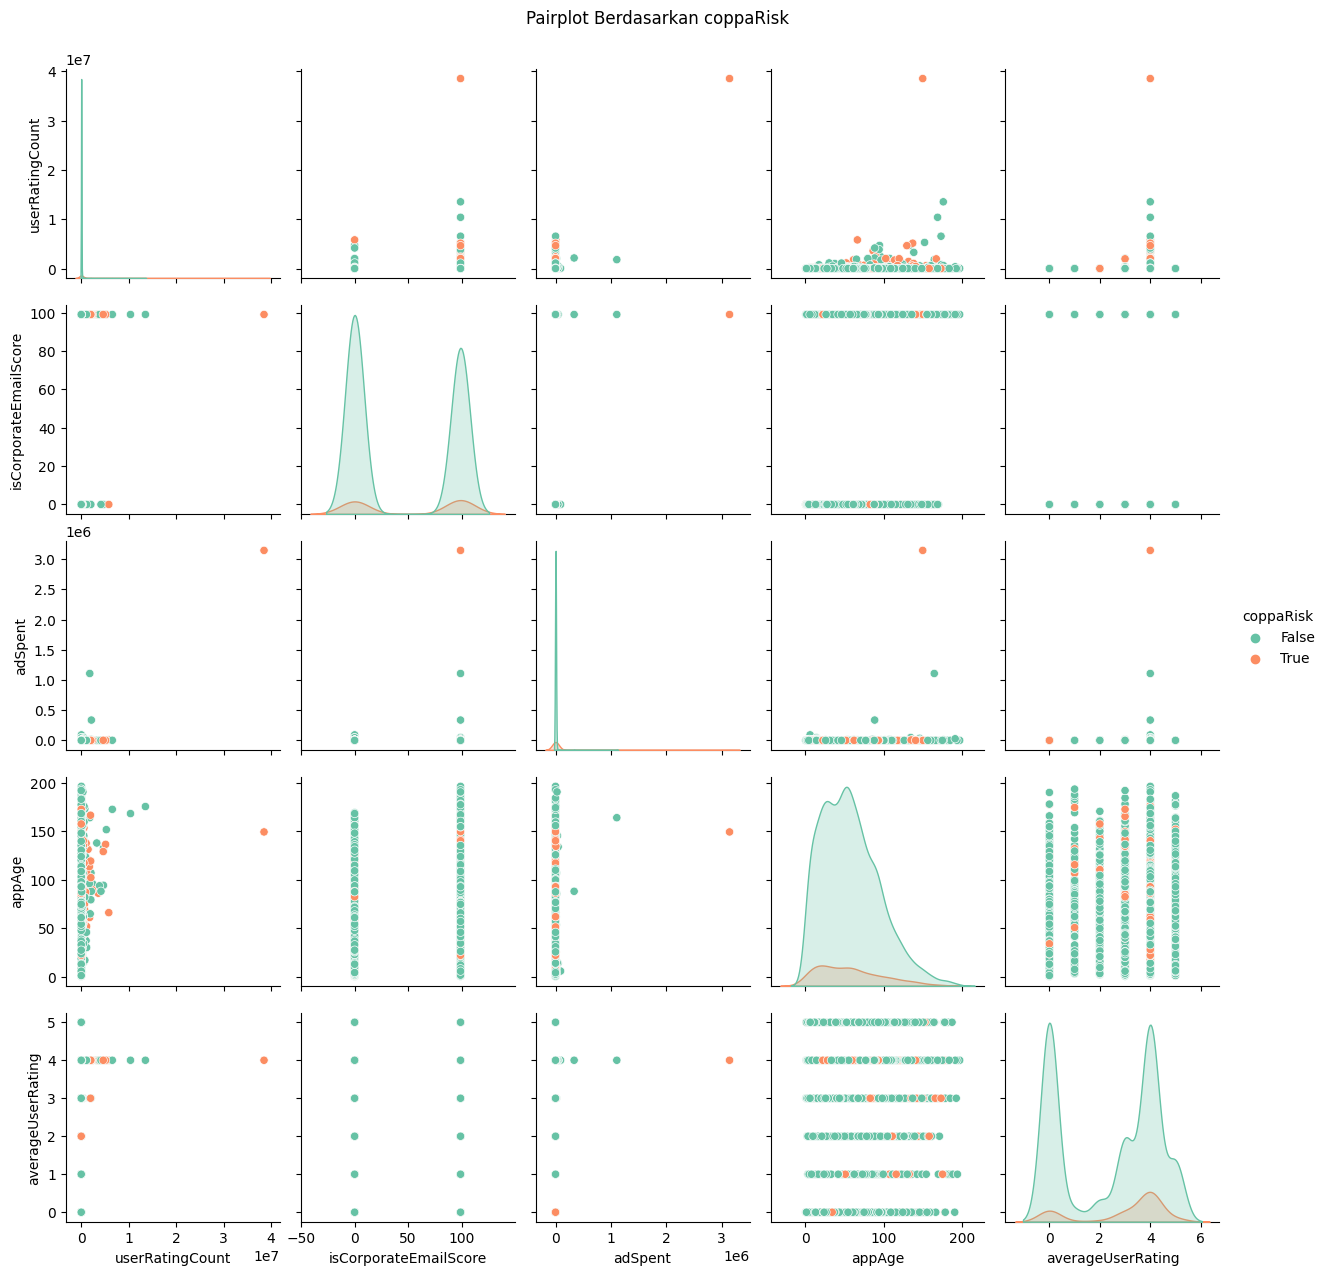

In [256]:
numerical_label = numerical + ['coppaRisk']

sns.pairplot(train_label[numerical_label], hue='coppaRisk', palette='Set2')
plt.suptitle('Pairplot Berdasarkan coppaRisk', y=1.02)
plt.show()

## Numerical Values Correlation

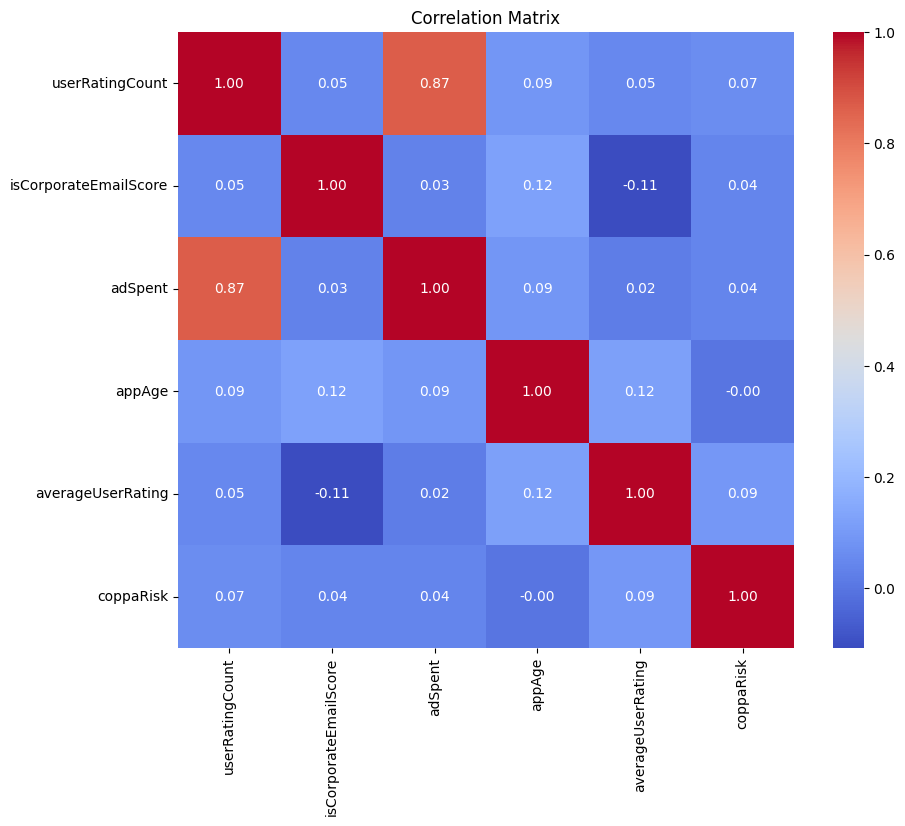

In [257]:
corr_matrix = train_label.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

## Downloads Unofficial Values

In [258]:
playstore_categories = {
    'All', 'Android Wear', 'Application', 'Art & Design', 'Auto & Vehicles', 'Beauty',
    'Books & Reference', 'Business', 'Comics', 'Communication', 'Dating', 'Education',
    'Entertainment', 'Events', 'Finance', 'Food & Drink', 'Health & Fitness',
    'House & Home', 'Lifestyle', 'Maps & Navigation', 'Medical', 'Music & Audio',
    'News & Magazines', 'Parenting', 'Personalization', 'Photography', 'Productivity',
    'Shopping', 'Social', 'Sports', 'Tools', 'Travel & Local', 'Video Players & Editors',
    'Weather', 'Game', 'Family', 'Game Action', 'Game Adventure', 'Game Arcade',
    'Game Board', 'Game Card', 'Game Casino', 'Game Casual', 'Game Educational',
    'Game Music', 'Game Puzzle', 'Game Racing', 'Game Role Playing', 'Game Simulation',
    'Game Sports', 'Game Strategy', 'Game Trivia', 'Game Word', 'Family Action & Adventure',
    'Family Brain Games', 'Family Creativity', 'Family Education', 'Family Music & Video',
    'Family Pretend Play'
}

appstore_categories = {
    "All","Books","Business","Developer Tools","Education","Entertainment","Finance","Food & Drink",
    "Games","Graphics & Design","Health & Fitness","Lifestyle","Magazines & Newspapers","Medical",
    "Music","Navigation","News","Photo & Video","Productivity","Reference","Social Networking",
    "Shopping","Sports","Travel","Utilities","Weather","Game Action","Game Adventure","Game Casual",
    "Game Board","Game Card","Game Casino","Game Family","Game Music","Game Puzzle","Game Racing",
    "Game Role Playing","Game Simulation","Game Sports","Game Strategy","Game Trivia","Game Word"
}

train_genres = set(df['primaryGenreName'].dropna().unique())
invalid_genres_playstore = train_genres - playstore_categories
invalid_genres_appstore = train_genres - appstore_categories
invalid_genres_marketplaces = train_genres - playstore_categories - appstore_categories

print("Genre yang tidak ada di daftar resmi Playstore:", invalid_genres_playstore)
print()
print("Genre yang tidak ada di daftar resmi App Store:", invalid_genres_appstore)
print()
print("Genre yang tidak ada di daftar resmi 2 App Marketplace:", invalid_genres_marketplaces)

Genre yang tidak ada di daftar resmi Playstore: {'Games', 'Magazines & Newspapers', 'Utilities', 'Book', 'Photo & Video', 'Reference', 'Stickers', 'Social Networking', 'Travel', 'Libraries & Demo', 'Developer Tools', 'Music', 'Navigation', 'News', 'Graphics & Design'}

Genre yang tidak ada di daftar resmi App Store: {'Comics', 'Maps & Navigation', 'Photography', 'Books & Reference', 'Parenting', 'Communication', 'Libraries & Demo', 'Video Players & Editors', 'House & Home', 'Travel & Local', 'Auto & Vehicles', 'Stickers', 'Music & Audio', 'News & Magazines', 'Events', 'Dating', 'Personalization', 'Book', 'Social', 'Art & Design', 'Beauty', 'Tools'}

Genre yang tidak ada di daftar resmi 2 App Marketplace: {'Book', 'Libraries & Demo', 'Stickers'}


## Train & Test developerCountry Values

In [259]:
train_countries = set(train['developerCountry'].dropna().unique())
test_countries = set(test['developerCountry'].dropna().unique())

print("developerCountry which doesn't exist in Train but exist in Test: " + str(test_countries - train_countries) + '\n')
print("developerCountry which doesn't exist in Test but exist in Train: " + str(train_countries - test_countries))

developerCountry which doesn't exist in Train but exist in Test: {'VENEZUELA (BOLIVARIAN REPUBLIC OF)', 'UGANDA', 'TUNISIA', 'BOSNIA AND HERZEGOVINA', 'TOGO', 'CAMEROON', 'DOMINICA', 'CROATIA', 'MONTENEGRO', 'SLOVAKIA', 'VIETNAM', 'RWANDA', 'SAINT VINCENT AND THE GRENADINES', 'MAURITIUS', 'PARAGUAY'}

developerCountry which doesn't exist in Test but exist in Train: {'BAHRAIN', 'LEBANON', 'BELGIUM', 'QATAR', 'ALGERIA', 'ALBANIA', "COTE D'IVOIRE", 'GREECE', 'SENEGAL', 'ANDORRA', 'ISLE OF MAN', 'DOMINICAN REPUBLIC', 'PERU', 'BRUNEI DARUSSALAM', 'MALDIVES', 'MONGOLIA', 'NICARAGUA', 'GREENLAND', 'VENEZUELA', 'ANGOLA', 'STATUTORY MASKING ENABLED', 'BELIZE', 'OMAN', 'UZBEKISTAN', 'BURUNDI', 'PANAMA', 'HONDURAS', 'NIGERIA', 'GUATEMALA', 'IRAQ', 'CAYMAN ISLANDS', 'GHANA', 'PERSONAL DATA, CAN NOT BE PUBLICLY DISCLOSED ACCORDING TO APPLICABLE LAWS.', 'TAIWAN, PROVINCE OF CHINA', 'PORTUGAL', 'KYRGYZSTAN', 'BRITISH VIRGIN ISLANDS', 'GIBRALTAR', 'ZIMBABWE', 'LITHUANIA'}


## Train & Test countryCode Values

In [260]:
train_countries = set(train['countryCode'].dropna().unique())
test_countries = set(test['countryCode'].dropna().unique())

print("countryCode which doesn't exist in Train but exist in Test: " + str(test_countries - train_countries) + '\n')
print("countryCode which doesn't exist in Test but exist in Train: " + str(train_countries - test_countries))

countryCode which doesn't exist in Train but exist in Test: {'ZW', 'GP', 'SL', 'ET', 'AL', 'MD', 'NP', 'NE'}

countryCode which doesn't exist in Test but exist in Train: {'HN', 'AF', 'EE', 'AT', 'MK', 'MM', 'UY', 'SN', 'SX', 'JO', 'BG', 'BH', 'SD', 'DJ', 'RE', 'HR', 'GY', 'GE', 'JM', 'DK', 'GU', 'IR', 'NZ', 'PY', 'SK', 'MN', 'CD', 'PR', 'CM', 'BJ', 'NI', 'CY', 'PA', 'GR', 'LK'}


## Train & Test primaryGenreName Values

In [261]:
train_countries = set(train['primaryGenreName'].dropna().unique())
test_countries = set(test['primaryGenreName'].dropna().unique())

print("primaryGenreName which doesn't exist in Train but exist in Test: " + str(test_countries - train_countries) + '\n')
print("primaryGenreName which doesn't exist in Test but exist in Train: " + str(train_countries - test_countries))

primaryGenreName which doesn't exist in Train but exist in Test: set()

primaryGenreName which doesn't exist in Test but exist in Train: {'Magazines & Newspapers'}


## isCorporateEmailScore Values

In [262]:
print(f"isCorporateEmailScore Unique Values: {df['isCorporateEmailScore'].dropna().unique()}")

isCorporateEmailScore Unique Values: [99.  0.]


## userRatingCount and averageUserRating Exploration

### Correlation Matrix on Both Column

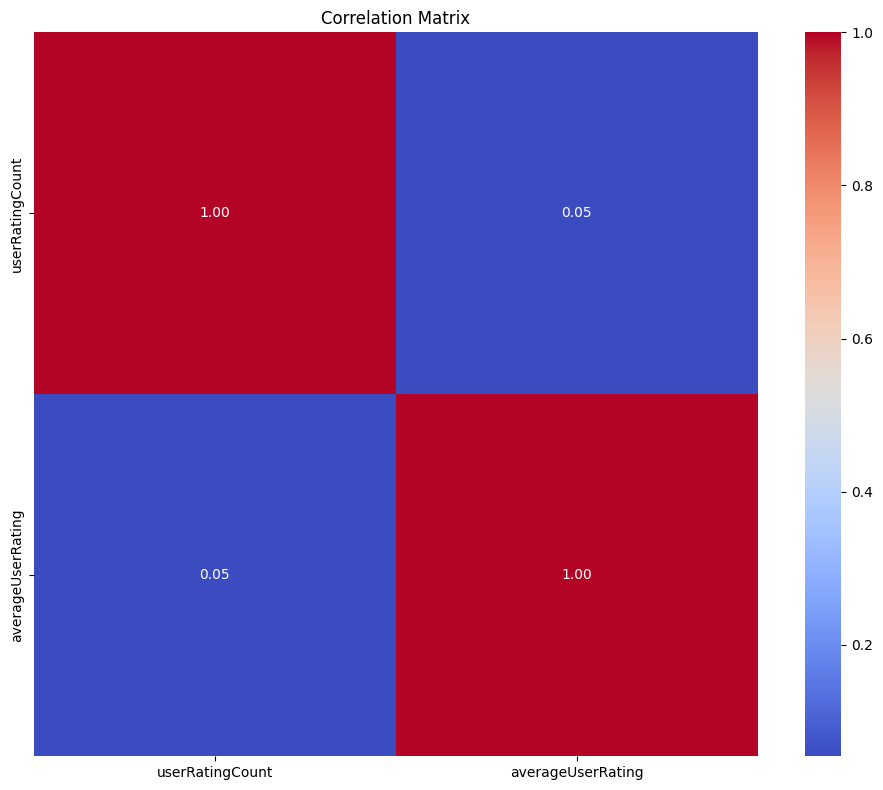

In [263]:
rating_corr_matrix = df[['userRatingCount', 'averageUserRating']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(rating_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

### Different Count on both column

In [264]:
df[(df['userRatingCount'] == 0) & (df['averageUserRating'] != 0) & (df['averageUserRating'].notna())].head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating
20,UNITED STATES,GLOBAL,0,Business,10 - 50,GLOBAL,True,NaN,NaN,99.0,NaN,91.233333,5.0,NaN,low,low
33,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Events,5 - 10,GLOBAL,NaN,NaN,NaN,0.0,NaN,89.633333,5.0,NaN,medium,low
73,NETHERLANDS,GLOBAL,0,Travel & Local,100 - 500,GLOBAL,True,False,high,99.0,NaN,121.366667,3.0,NaN,low,low
111,REPUBLIC OF KOREA,GLOBAL,0,Books & Reference,10 - 50,GLOBAL,True,False,high,99.0,NaN,80.533333,5.0,NaN,low,low
112,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Education,10000 - 50000,GLOBAL,True,NaN,NaN,99.0,NaN,59.933333,3.0,NaN,low,low


In [265]:
len(df[(df['userRatingCount'] == 0) & (df['averageUserRating'] != 0) & (df['averageUserRating'].notna())])

359

In [266]:
df[(df['averageUserRating'] == 0) & (df['userRatingCount'] != 0) & (df['userRatingCount'].notna())].head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating
6,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,237,Games,NaN,GLOBAL,True,NaN,NaN,NaN,NaN,88.266667,0.0,medium,low,low
179,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,1,Shopping,NaN,GLOBAL,True,NaN,NaN,NaN,NaN,10.200000,0.0,NaN,low,low
200,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,6,Shopping,NaN,GLOBAL,True,NaN,NaN,99.0,NaN,16.000000,0.0,NaN,low,low
206,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,1,Games,NaN,GLOBAL,True,NaN,NaN,NaN,NaN,97.866667,0.0,low,low,low
261,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,6,Music,NaN,GLOBAL,True,NaN,NaN,NaN,NaN,53.066667,0.0,NaN,low,low


In [267]:
len(df[(df['averageUserRating'] == 0) & (df['userRatingCount'] != 0) & (df['userRatingCount'].notna())])

124

## Privacy & TOS Links Exploration

### Their Value Counts

In [268]:
df['hasPrivacyLink'].value_counts()

hasPrivacyLink
True     8841
False      93
Name: count, dtype: int64

In [269]:
df['hasTermsOfServiceLink'].value_counts()

hasTermsOfServiceLink
False    2067
True     1337
Name: count, dtype: int64

In [270]:
df['hasTermsOfServiceLinkRating'].value_counts()

hasTermsOfServiceLinkRating
high    2067
low     1337
Name: count, dtype: int64

### Checking Their Values

#### hasPrivacyLink and hasTermsOfServiceLink

In [271]:
df[(df['hasPrivacyLink'] == False) & (df['hasTermsOfServiceLink'] == True)].head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating
1064,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Food & Drink,NaN,GLOBAL,False,True,low,NaN,NaN,79.133333,0.0,NaN,low,low
2258,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Sports,NaN,GLOBAL,False,True,low,NaN,NaN,116.633333,0.0,NaN,high,low
2357,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Business,NaN,GLOBAL,False,True,low,99.0,NaN,93.066667,0.0,NaN,low,low
2535,NIGERIA,GLOBAL,0,House & Home,1000 - 5000,GLOBAL,False,True,low,99.0,NaN,75.766667,3.0,NaN,low,low
2536,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Education,100 - 500,GLOBAL,False,True,low,0.0,NaN,101.033333,5.0,NaN,low,low


In [272]:
len(df[(df['hasPrivacyLink'] == False) & (df['hasTermsOfServiceLink'] == True)])

15

In [273]:
len(df[(df['hasPrivacyLink'] == False) & (df['hasTermsOfServiceLink'].notna())])

93

#### hasPrivacyLink and hasTermsOfServiceLinkRating

In [274]:
df[(df['hasPrivacyLink'] == False) & (df['hasTermsOfServiceLinkRating'].notna())].head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating
60,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,News & Magazines,10 - 50,GLOBAL,False,False,high,99.0,NaN,62.866667,NaN,NaN,low,low
247,RUSSIAN FEDERATION,GLOBAL,28,Games,500 - 1000,GLOBAL,False,False,high,0.0,NaN,141.066667,4.0,NaN,low,low
293,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Business,50 - 100,GLOBAL,False,False,high,99.0,NaN,72.133333,0.0,NaN,low,low
522,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Education,NaN,GLOBAL,False,False,high,NaN,NaN,93.233333,0.0,NaN,low,low
529,IRELAND,GLOBAL,3,Utilities,NaN,GLOBAL,False,False,high,NaN,NaN,103.200000,3.0,NaN,low,low


In [275]:
len(df[(df['hasPrivacyLink'] == False) & (df['hasTermsOfServiceLinkRating'].notna())])

93

#### hasTermsOfServiceLink and hasTermsOfServiceLinkRating

In [276]:
df[(df['hasTermsOfServiceLink'] == False) & (df['hasTermsOfServiceLinkRating'].notna())].head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating
14,FINLAND,GLOBAL,31,Games,50000 - 100000,tablet,True,False,high,0.0,NaN,8.966667,3.0,NaN,low,low
18,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,112,Entertainment,10000 - 50000,GLOBAL,True,False,high,0.0,NaN,60.366667,4.0,medium,high,low
35,VIET NAM,EMEA,2653,Games,100000 - 500000,smartphone,True,False,high,0.0,126.904498,5.900000,4.0,NaN,low,low
42,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,20,Education,100 - 500,GLOBAL,True,False,high,99.0,NaN,17.633333,5.0,NaN,low,low
43,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Education,NaN,GLOBAL,True,False,high,0.0,NaN,41.400000,0.0,NaN,low,low


In [277]:
len(df[(df['hasTermsOfServiceLink'] == False) & (df['hasTermsOfServiceLinkRating'].notna())])

2067

#### When hasTermsOfServiceLink has **TRUE** value, hasTermsOfServiceLinkRating only has **LOW** value

#### When hasTermsOfServiceLink has **False** value, hasTermsOfServiceLinkRating only has **HIGH** value

#### When hasTermsOfServiceLink and hasTermsOfServiceLinkRating values are **NULL**

In [278]:
df[(df['hasTermsOfServiceLink'] == False) & (df['hasTermsOfServiceLinkRating'].notna())]['hasTermsOfServiceLinkRating'].unique()

array(['high'], dtype=object)

In [279]:
df[(df['hasTermsOfServiceLink'] == True) & (df['hasTermsOfServiceLinkRating'].notna())]['hasTermsOfServiceLinkRating'].unique()

array(['low'], dtype=object)

In [280]:
len(df[(df['hasTermsOfServiceLink'].isna()) & (df['hasTermsOfServiceLinkRating'].notna())])

0

In [281]:
len(df[(df['hasTermsOfServiceLink'].notna()) & (df['hasTermsOfServiceLinkRating'].isna())])

0

In [282]:
len(df[(df['hasTermsOfServiceLink'] == True) & (df['hasTermsOfServiceLinkRating'] == 'high')])

0

In [283]:
len(df[(df['hasTermsOfServiceLink'] == False) & (df['hasTermsOfServiceLinkRating'] == 'low')])

0

## CoppaRisk (Target) Value Counts

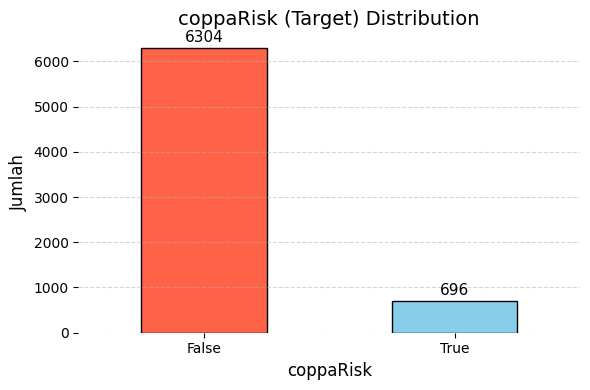

In [284]:
counts = train_label['coppaRisk'].value_counts()

plt.figure(figsize=(6, 4))
ax = counts.plot(kind='bar', color=['tomato', 'skyblue'], edgecolor='black')

plt.title('coppaRisk (Target) Distribution', fontsize=14)
plt.xlabel('coppaRisk', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for i, value in enumerate(counts):
    ax.text(i, value + counts.max()*0.01, str(value), ha='center', va='bottom', fontsize=11)

for spine in ax.spines.values():
    spine.set_linewidth(0)

plt.tight_layout()
plt.show()


## coppaRisk True Ratio on Categorical Columns

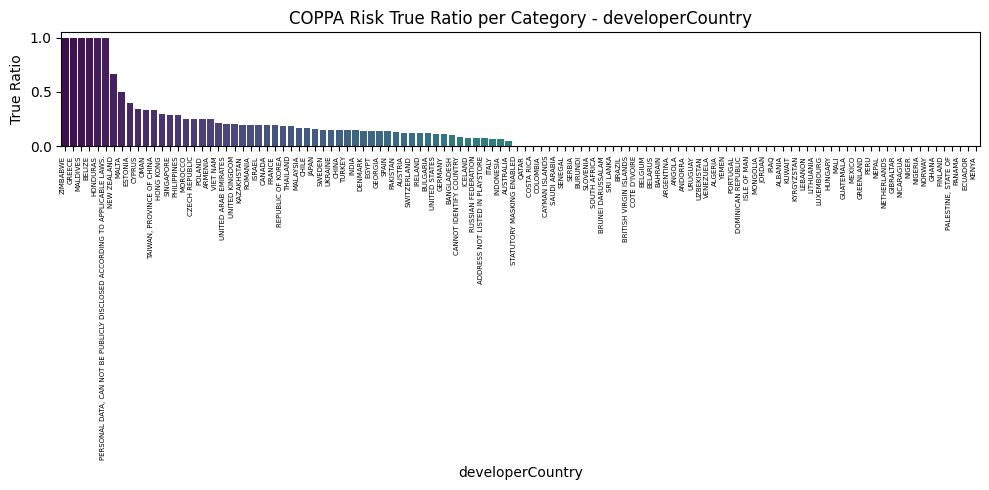

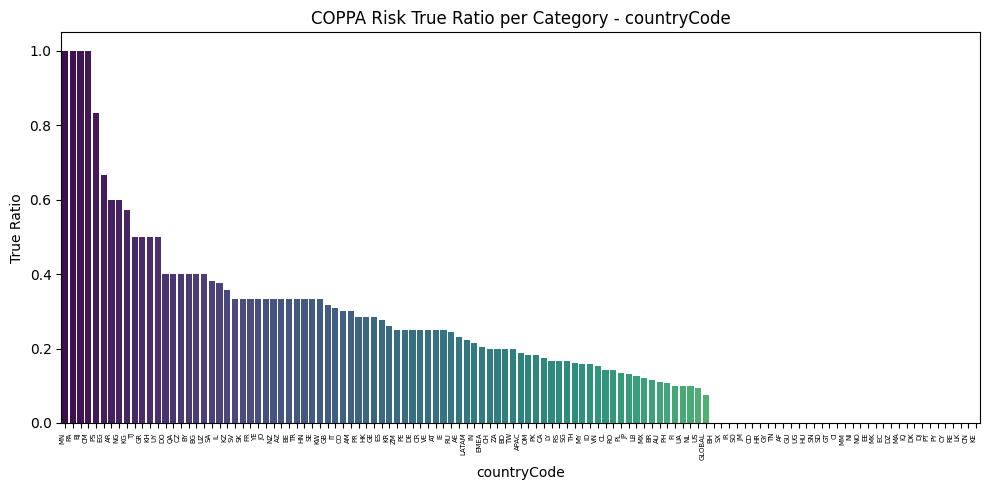

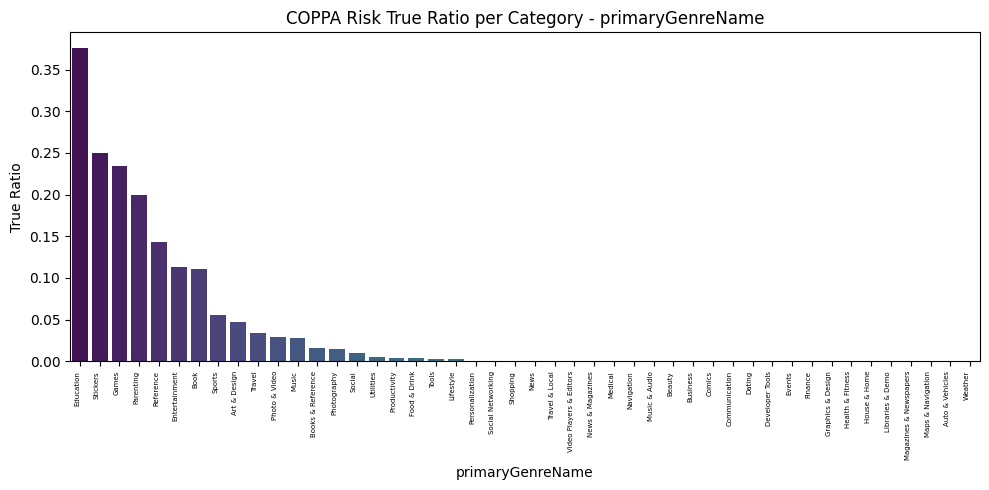

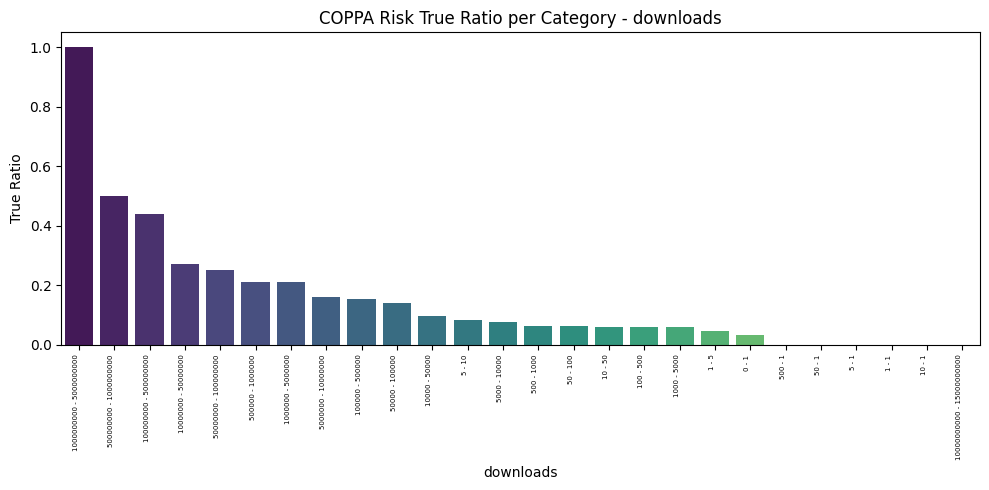

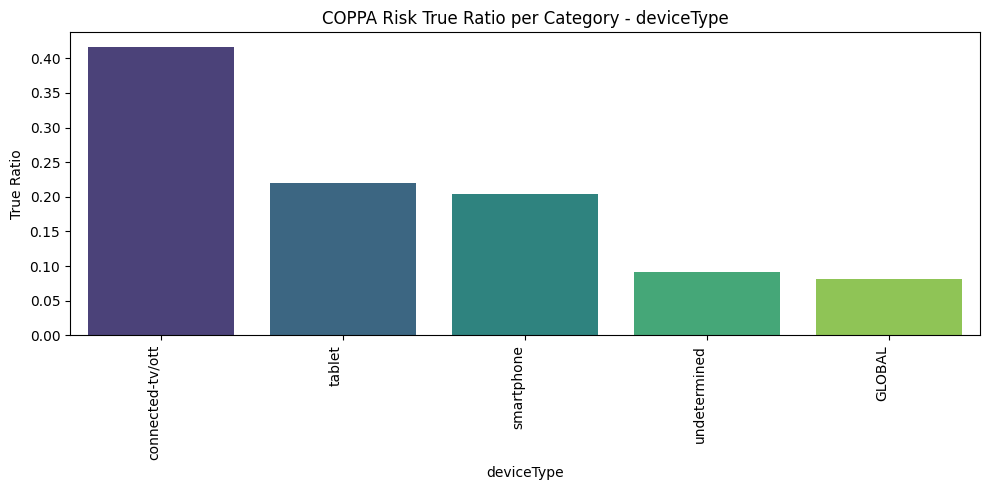

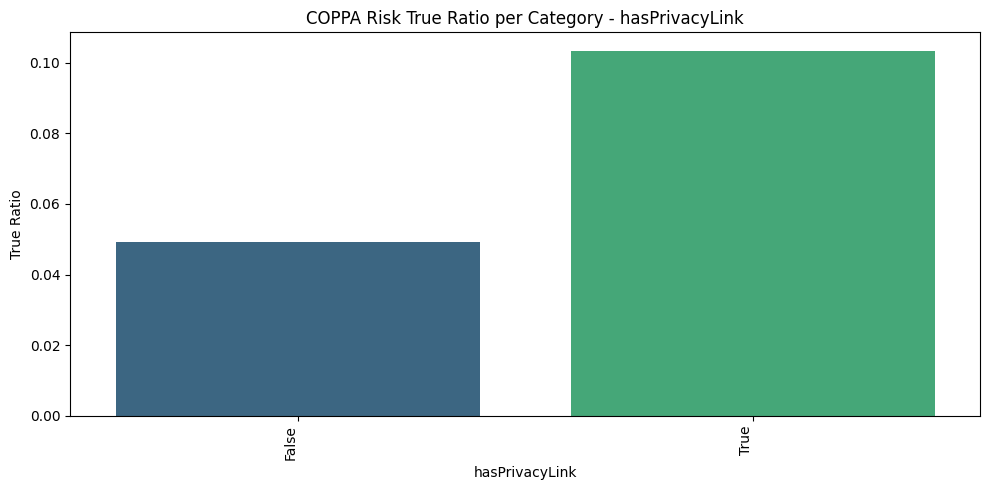

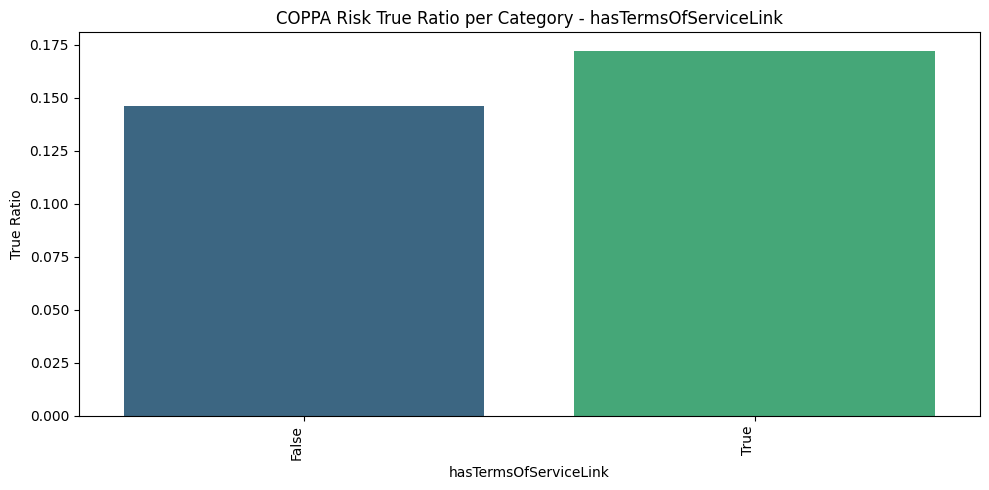

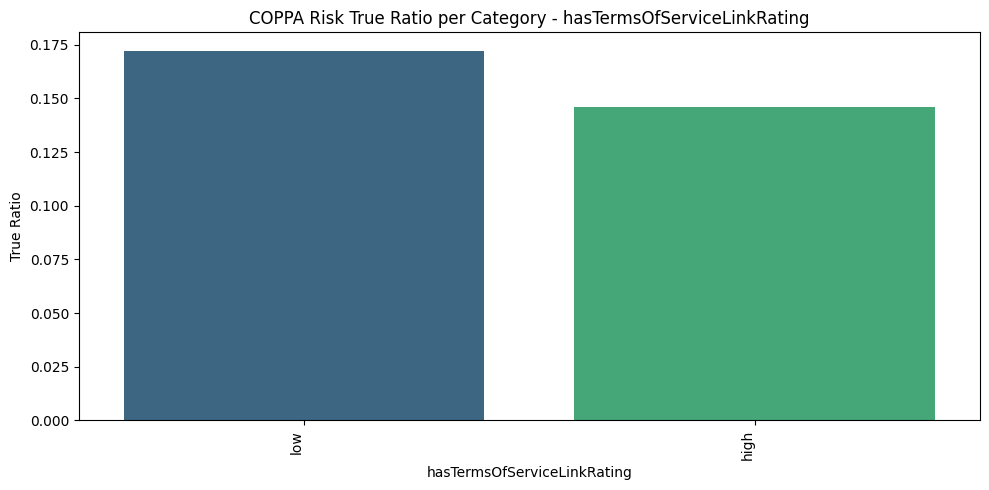

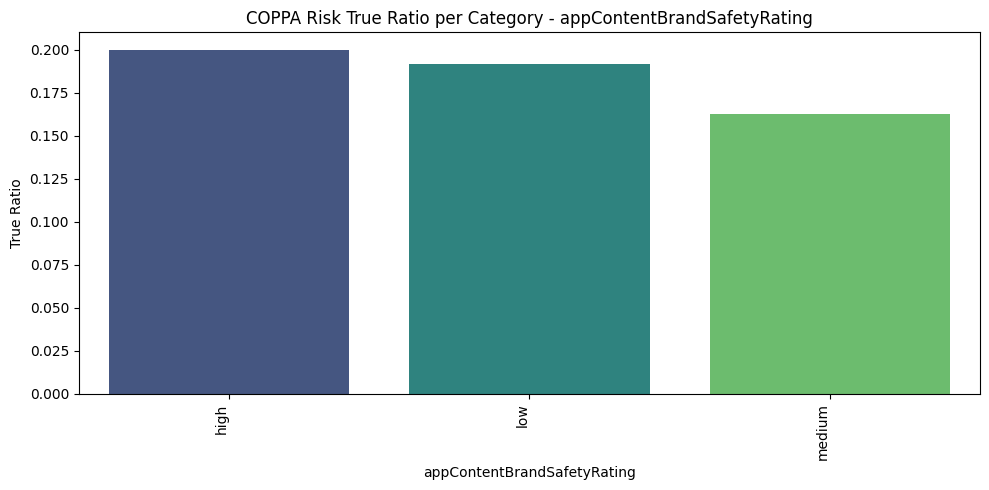

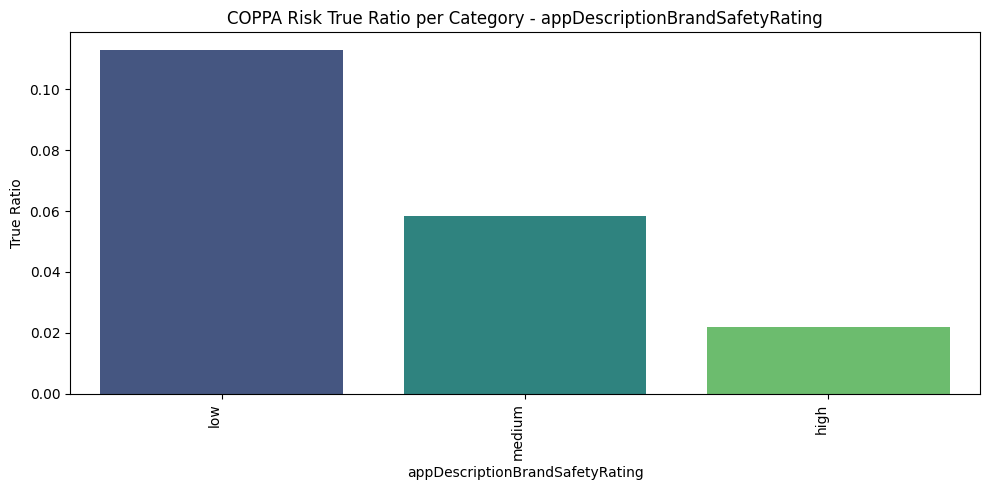

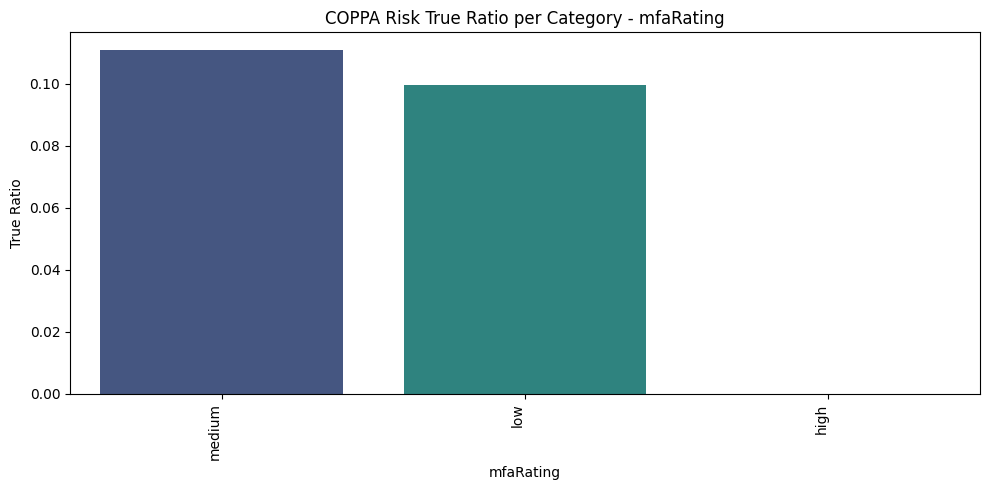

In [285]:
for col in categorical:
    # Hitung rasio coppaRisk=True per kategori
    ratio_df = (
        train_label.groupby(col)['coppaRisk']
        .mean()
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={'coppaRisk': 'True Ratio'})
    )

    max_label_length = 10

    train_label[col] = train_label[col].astype(str).apply(
        lambda x: x if len(x) <= max_label_length else x[:max_label_length] + '...'
    )

    num_categories = train_label[col].nunique()
    if num_categories > 20:
        fontsize = 5
    else:
        fontsize = 10

    plt.figure(figsize=(10, 5))
    sns.barplot(data=ratio_df, x=col, y='True Ratio', palette='viridis')
    plt.xticks(rotation=90, ha='right', fontsize=fontsize)
    plt.title(f'COPPA Risk True Ratio per Category - {col}')
    plt.tight_layout()
    plt.show()

## coppaRisk True Ratio on Numerical Columns

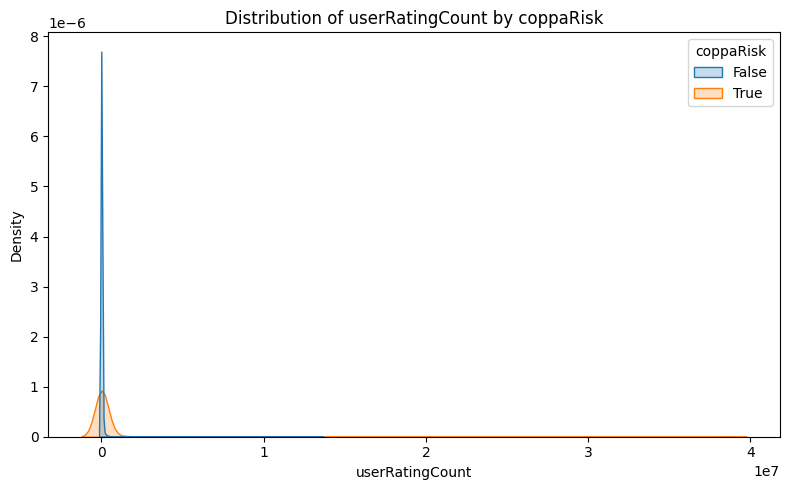

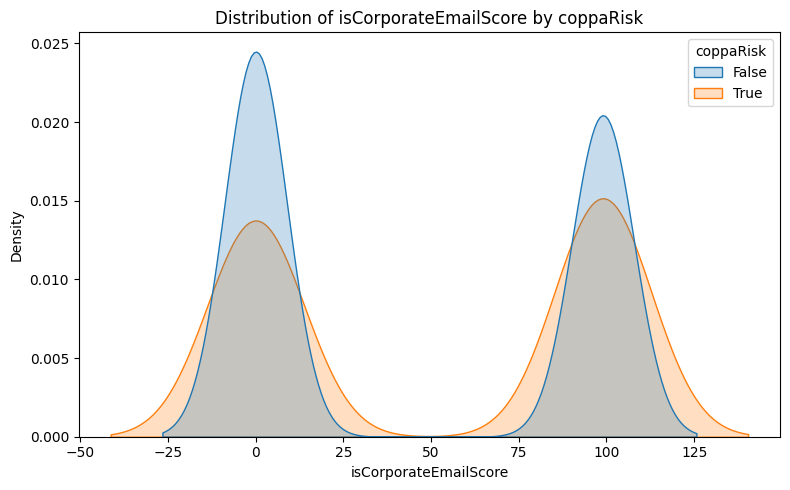

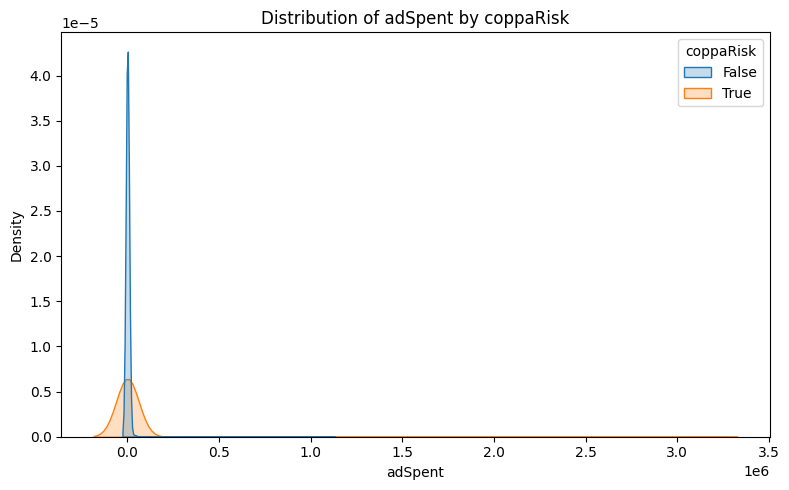

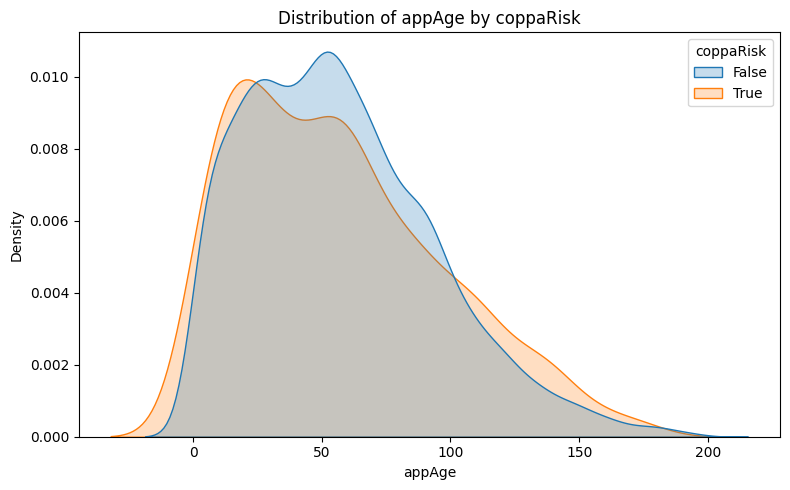

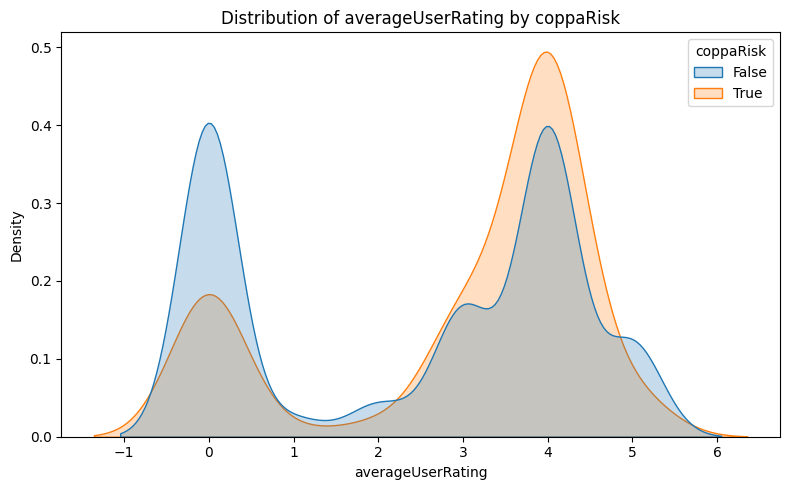

In [286]:
for col in numerical:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=train_label, x=col, hue='coppaRisk', common_norm=False, fill=True)
    plt.title(f'Distribution of {col} by coppaRisk')
    plt.tight_layout()
    plt.show()

# Preprocessing

## Numerical Columns

### adSpent
- **UNUSED**

In [287]:
# train['adSpent'] = np.log1p(train['adSpent'])
# test['adSpent'] = np.log1p(test['adSpent'])

## Feature Transformation

### Removing developerCountry Train values that doesn't appear on Test and vice versa
 - **UNUSED**

In [288]:
# negara_tertentu = ['GUATEMALA', 'ANGOLA', 'LITHUANIA', 'MONGOLIA', 'ISLE OF MAN', 'ZIMBABWE', 'LEBANON','SENEGAL', 'UZBEKISTAN', 'KYRGYZSTAN', 'TAIWAN, PROVINCE OF CHINA', 'STATUTORY MASKING ENABLED','NICARAGUA', 'GHANA', 'GREECE', 'OMAN', 'DOMINICAN REPUBLIC', 'CAYMAN ISLANDS','BRITISH VIRGIN ISLANDS', 'BRUNEI DARUSSALAM', 'QATAR', 'BELIZE', 'GIBRALTAR', 'VENEZUELA',"COTE D'IVOIRE", 'HONDURAS', 'ALBANIA','PERSONAL DATA, CAN NOT BE PUBLICLY DISCLOSED ACCORDING TO APPLICABLE LAWS.','PORTUGAL', 'BELGIUM', 'IRAQ', 'PERU', 'BURUNDI', 'NIGERIA', 'GREENLAND','PANAMA', 'ALGERIA', 'ANDORRA', 'BAHRAIN', 'MALDIVES']
# train.loc[train['developerCountry'].isin(negara_tertentu), 'developerCountry'] = np.nan

# negara_tertentu2 = ['CROATIA', 'MAURITIUS', 'SLOVAKIA', 'TOGO', 'UGANDA', 'PARAGUAY', 'MONTENEGRO', 'RWANDA', 'TUNISIA', 'BOSNIA AND HERZEGOVINA', 'SAINT VINCENT AND THE GRENADINES', 'CAMEROON']
# test.loc[test['developerCountry'].isin(negara_tertentu), 'developerCountry'] = np.nan

# to_drop_idx = train[train['developerCountry'] == "PERSONAL DATA, CAN NOT BE PUBLICLY DISCLOSED ACCORDING TO APPLICABLE LAWS."].index
# train.drop(index=to_drop_idx, inplace=True)
# label.drop(index=to_drop_idx, inplace=True)

### primaryGenreName
 - **UNUSED**

In [289]:
# train['primaryGenreName'] = train['primaryGenreName'].replace('Developer Tools', 'Tools')
# train['primaryGenreName'] = train['primaryGenreName'].replace('Music', 'Music & Audio')
# train['primaryGenreName'] = train['primaryGenreName'].replace('Travel', 'Travel & Local')
# train['primaryGenreName'] = train['primaryGenreName'].replace('Photo & Video', 'Photography')
# train['primaryGenreName'] = train['primaryGenreName'].replace('Book', 'Books & Reference')
# train['primaryGenreName'] = train['primaryGenreName'].replace('Reference', 'Books & Reference')
# train['primaryGenreName'] = train['primaryGenreName'].replace('Libraries & Demo', 'Books & Reference')
# train['primaryGenreName'] = train['primaryGenreName'].replace('Graphics & Design', 'Art & Design')
# train['primaryGenreName'] = train['primaryGenreName'].replace('News', 'News & Magazines')
# train['primaryGenreName'] = train['primaryGenreName'].replace('Social Networking', 'Social')
# train['primaryGenreName'] = train['primaryGenreName'].replace('Navigation', 'Maps & Navigation')
# train['primaryGenreName'] = train['primaryGenreName'].replace('Magazines & Newspapers', 'News & Magazines')
# train['primaryGenreName'] = train['primaryGenreName'].replace('Stickers', 'Entertainment')
# train['primaryGenreName'] = train['primaryGenreName'].replace('Utilities', 'Personalization')

# test['primaryGenreName'] = test['primaryGenreName'].replace('Developer Tools', 'Tools')
# test['primaryGenreName'] = test['primaryGenreName'].replace('Music', 'Music & Audio')
# test['primaryGenreName'] = test['primaryGenreName'].replace('Travel', 'Travel & Local')
# test['primaryGenreName'] = test['primaryGenreName'].replace('Photo & Video', 'Photography')
# test['primaryGenreName'] = test['primaryGenreName'].replace('Book', 'Books & Reference')
# test['primaryGenreName'] = test['primaryGenreName'].replace('Reference', 'Books & Reference')
# test['primaryGenreName'] = test['primaryGenreName'].replace('Libraries & Demo', 'Books & Reference')
# test['primaryGenreName'] = test['primaryGenreName'].replace('Graphics & Design', 'Art & Design')
# test['primaryGenreName'] = test['primaryGenreName'].replace('News', 'News & Magazines')
# test['primaryGenreName'] = test['primaryGenreName'].replace('Social Networking', 'Social')
# test['primaryGenreName'] = test['primaryGenreName'].replace('Navigation', 'Maps & Navigation')
# test['primaryGenreName'] = test['primaryGenreName'].replace('Magazines & Newspapers', 'News & Magazines')
# test['primaryGenreName'] = test['primaryGenreName'].replace('Stickers', 'Entertainment')
# test['primaryGenreName'] = test['primaryGenreName'].replace('Utilities', 'Personalization')

### hasPrivacyLink && hasTermsOfServiceLink && hasTermsOfServiceLinkRating
 - **UNUSED**

In [290]:
# train.loc[(train['hasTermsOfServiceLink'] == False) & (train['hasTermsOfServiceLinkRating'].notnull()), 'hasTermsOfServiceLinkRating'] = False
# test.loc[(test['hasTermsOfServiceLink'] == False) & (test['hasTermsOfServiceLinkRating'].notnull()), 'hasTermsOfServiceLinkRating'] = False

# train.loc[(train['hasTermsOfServiceLink'] == False) & (train['hasTermsOfServiceLinkRating'].notnull()), 'hasTermsOfServiceLink'] = True
# test.loc[(test['hasTermsOfServiceLink'] == False) & (test['hasTermsOfServiceLinkRating'].notnull()), 'hasTermsOfServiceLink'] = True

# train.loc[train['hasPrivacyLink'].isnull(), ['hasPrivacyLink', 'hasTermsOfServiceLink', 'hasTermsOfServiceLinkRating']] = False
# test.loc[test['hasPrivacyLink'].isnull(), ['hasPrivacyLink', 'hasTermsOfServiceLink', 'hasTermsOfServiceLinkRating']] = False

# train.loc[(train['hasPrivacyLink'] == True) & (train['hasTermsOfServiceLink'].isnull()),['hasTermsOfServiceLink', 'hasTermsOfServiceLinkRating']] = False
# test.loc[(test['hasPrivacyLink'] == True) & (test['hasTermsOfServiceLink'].isnull()),['hasTermsOfServiceLink', 'hasTermsOfServiceLinkRating']] = False
# train['hasPrivacyLink'].value_counts()

### userRatingCount && averageUserRating
 - **UNUSED**

In [291]:
# train.loc[(train['userRatingCount'] == 0) & (train['averageUserRating'] > 0), 'userRatingCount'] = np.nan
# test.loc[(test['userRatingCount'] == 0) & (test['averageUserRating'] > 0), 'userRatingCount'] = np.nan

# train.loc[(train['userRatingCount'] > 0) & (train['averageUserRating'] == 0), 'averageUserRating'] = np.nan
# test.loc[(test['userRatingCount'] > 0) & (test['averageUserRating'] == 0), 'averageUserRating'] = np.nan

## Category Grouping
Grouping similar categories into a single class to reduce the number of unique categories.

### developerCountry

In [292]:
test['developerCountry'] = test['developerCountry'].replace('VIETNAM', 'VIET NAM')
test['developerCountry'] = test['developerCountry'].replace('DOMINICA', 'DOMINICAN REPUBLIC')
test['developerCountry'] = test['developerCountry'].replace('VENEZUELA (BOLIVARIAN REPUBLIC OF)', 'VENEZUELA')

unknown_values = {
    'ADDRESS NOT LISTED IN PLAYSTORE',
    'CANNOT IDENTIFY COUNTRY',
    'PERSONAL DATA, CAN NOT BE PUBLICLY DISCLOSED ACCORDING TO APPLICABLE LAWS.',
    'STATUTORY MASKING ENABLED',
}

def map_dev_country(value):
    if value in unknown_values:
        return 'unknown'
    elif pd.isna(value):
        return value
    else:
        return value

train['developerCountry'] = train['developerCountry'].apply(map_dev_country)
test['developerCountry'] = test['developerCountry'].apply(map_dev_country)

train['developerCountry'].value_counts()

developerCountry
unknown              5109
UNITED STATES         324
CHINA                 150
INDIA                 131
REPUBLIC OF KOREA      95
                     ... 
CAYMAN ISLANDS          1
COTE D'IVOIRE           1
ISLE OF MAN             1
GIBRALTAR               1
MALDIVES                1
Name: count, Length: 111, dtype: int64

### countryCode

In [293]:
country_category_map = {
    'GLOBAL': 'global',
    'EMEA': 'continent',
    'LATAM': 'continent',
    'APAC': 'continent', 
}

def map_country(val):
    if pd.isna(val):              
        return val
    elif val in country_category_map:
        return country_category_map[val]
    else:
        return val          

train['countryCode'] = train['countryCode'].apply(map_country)
test['countryCode'] = test['countryCode'].apply(map_country)

print(train['countryCode'].value_counts(dropna=False))

countryCode
global       5802
continent     182
US             74
NaN            64
RU             41
             ... 
SX              1
PY              1
NO              1
MN              1
IR              1
Name: count, Length: 118, dtype: int64


### primaryGenreName
- **UNUSED**
- Map Categories that is NOT in Playstore & Appstore to INVALID

In [294]:
# train['primaryGenreName'] = train['primaryGenreName'].replace(['Book', 'Libraries & Demo', 'Stickers'], 'INVALID')

### deviceType
 - **UNUSED**


In [295]:
# device_type_map = {
#     'smartphone': 'mobile',
#     'tablet': 'mobile',
#     'connected-tv/ott': 'tv',
#     'GLOBAL': 'Global',
#     'undetermined': 'undetermined'
# }

# train['deviceType'] = train['deviceType'].map(device_type_map)
# test['deviceType'] = test['deviceType'].map(device_type_map)
# train['deviceType'] = train['deviceType'].map({'undetermined': 0, 'tv': 1, 'mobile': 2, 'Global': 3})
# test['deviceType'] = test['deviceType'].map({'undetermined': 0, 'tv': 1, 'mobile': 2, 'Global': 3})
# train['deviceType'].value_counts()

## Binary Encoding (Boolean-to-integer Mapping)

### isCorporateEmailScore
- **UNUSED**

In [296]:
# train['isCorporateEmailScore'] = train['isCorporateEmailScore'].map({99: 1, 0: 0})
# test['isCorporateEmailScore'] = test['isCorporateEmailScore'].map({99: 1, 0: 0})

### hasPrivacyLink

In [297]:
train['hasPrivacyLink'] = train['hasPrivacyLink'].map({True: 1, False: 0})
test['hasPrivacyLink'] = test['hasPrivacyLink'].map({True: 1, False: 0})

### hasTermsOfServiceLink

In [298]:
train['hasTermsOfServiceLink'] = train['hasTermsOfServiceLink'].map({True: 1, False: 0})
test['hasTermsOfServiceLink'] = test['hasTermsOfServiceLink'].map({True: 1, False: 0})

## Ordinal Encoding

### downloads (Median Mapping)
- **UNUSED**
- Map to Tuple, then get Median from the tuple

In [299]:
# corrections = {
#     "1 - 1": "0 - 1",
#     "5 - 1": "1 - 5",
#     "10 - 1": "1 - 10",
#     "50 - 1": "1 - 50",
#     "500 - 1": "1 - 500"
# }

# train['downloads_median'] = train['downloads'].replace(corrections)
# test['downloads_median'] = test['downloads'].replace(corrections)

# tier_ranges = {'0 - 1': (0.0, 1.0),'1 - 5': (1.0, 5.0), '1 - 10': (1.0, 10.0), '5 - 10': (5.0, 10.0), '1 - 50': (1.0, 50.0), '10 - 50': (10.0, 50.0), 
#                '50 - 100': (50.0, 100.0), '1 - 500': (1.0, 500.0), '100 - 500': (100.0, 500.0), '500 - 1000': (500.0, 1000.0),
#                '1000 - 5000': (1000.0, 5000.0), '5000 - 10000': (5000.0, 10000.0), '10000 - 50000': (10000.0, 50000.0),
#                '50000 - 100000': (50000.0, 100000.0), '100000 - 500000': (100000.0, 500000.0), 
#                '500000 - 1000000': (500000.0, 1000000.0), '1000000 - 5000000': (1000000.0, 5000000.0), 
#                '5000000 - 10000000': (5000000.0, 10000000.0), '10000000 - 50000000': (10000000.0, 50000000.0), 
#                '50000000 - 100000000': (50000000.0, 100000000.0), '100000000 - 500000000': (100000000.0, 500000000.0), 
#                '500000000 - 1000000000': (500000000.0, 1000000000.0), 
#                '1000000000 - 5000000000': (1000000000.0, 5000000000.0), 
#                '10000000000 - 15000000000': (10000000000.0, 15000000000.0)}

# def get_median_from_range(tier):
#     if tier not in tier_ranges:
#         return np.nan
#     lower, upper = tier_ranges[tier]
#     return (lower + upper) / 2

# train['downloads_median'] = train['downloads_median'].apply(get_median_from_range)
# test['downloads_median'] = test['downloads_median'].apply(get_median_from_range)

### downloads (Ordinal Mapping)

In [300]:
downloads_corrections = {
    "5 - 1": "1 - 5",
    "10 - 1": "5 - 10",
    "50 - 1": "10 - 50",
    "500 - 1": "100 - 500"
}

train['downloads'] = train['downloads'].replace(downloads_corrections)
test['downloads'] = test['downloads'].replace(downloads_corrections)

download_tiers = [
    "0 - 1", "1 - 1", "1 - 5", "5 - 10", "10 - 50", "50 - 100",
    "100 - 500", "500 - 1000", 
    "1000 - 5000", "5000 - 10000", "10000 - 50000", "50000 - 100000",
    "100000 - 500000", "500000 - 1000000", "1000000 - 5000000", 
    "5000000 - 10000000", "10000000 - 50000000", "50000000 - 100000000",
    "100000000 - 500000000", "500000000 - 1000000000", 
    "1000000000 - 5000000000", "10000000000 - 15000000000"
]

download_dict = {tier: i for i, tier in enumerate(download_tiers)}

train['downloads'] = train['downloads'].map(download_dict)
test['downloads'] = test['downloads'].map(download_dict)

print(train['downloads'].value_counts(dropna=False))

downloads
NaN     2149
6.0      700
4.0      674
8.0      591
10.0     396
7.0      324
5.0      310
12.0     270
14.0     248
2.0      225
3.0      210
9.0      185
16.0     173
11.0     169
13.0     124
15.0     111
0.0       63
18.0      34
17.0      28
1.0       11
21.0       2
19.0       2
20.0       1
Name: count, dtype: int64


### hasTermsOfServiceLinkRating

In [301]:
train['hasTermsOfServiceLinkRating'] = train['hasTermsOfServiceLinkRating'].map({'low': 1, 'medium': 2, 'high': 3})
test['hasTermsOfServiceLinkRating'] = test['hasTermsOfServiceLinkRating'].map({'low': 1, 'medium': 2, 'high': 3})

### appContentBrandSafetyRating

In [302]:
train['appContentBrandSafetyRating'] = train['appContentBrandSafetyRating'].map({'low': 1, 'medium':2, 'high': 3})
test['appContentBrandSafetyRating'] = test['appContentBrandSafetyRating'].map({'low': 1, 'medium':2, 'high': 3})

### appDescriptionBrandSafetyRating

In [303]:
train['appDescriptionBrandSafetyRating'] = train['appDescriptionBrandSafetyRating'].map({'low': 1, 'medium':2, 'high': 3})
test['appDescriptionBrandSafetyRating'] = test['appDescriptionBrandSafetyRating'].map({'low': 1, 'medium':2, 'high': 3})

### mfaRating

In [304]:
train['mfaRating'] = train['mfaRating'].map({'low': 1, 'medium':2, 'high': 3})
test['mfaRating'] = test['mfaRating'].map({'low': 1, 'medium':2, 'high': 3})

## Feature Engineering

### isCorporateEmail

In [305]:
threshold = 50

train['isCorporateEmail'] = train['isCorporateEmailScore'] > threshold  
test['isCorporateEmail'] = test['isCorporateEmailScore'] > threshold  

train['isCorporateEmail'] = train['isCorporateEmail'].map({True: 1, False: 0})
test['isCorporateEmail'] = test['isCorporateEmail'].map({True: 1, False: 0})

### genre_downloads
- **UNUSED**
- High Feature Importance but lowered AUC Score

In [306]:
# train['genre_downloads'] = train['primaryGenreName'] + "_" + train['downloads'].astype(str)
# test['genre_downloads'] = test['primaryGenreName'] + "_" + test['downloads'].astype(str)

### genre_rating
- **UNUSED**
- High Feature Importance but lowered AUC Score

In [307]:
# train['genre_rating'] = train['primaryGenreName'] + "_" + train['averageUserRating'].astype(str)
# test['genre_rating'] = test['primaryGenreName'] + "_" + test['averageUserRating'].astype(str)

### genre_corporate
- **UNUSED**
- High Feature Importance but lowered AUC Score

In [308]:
# train['genre_corporate'] = train['primaryGenreName'] + "_" + train['isCorporateEmailScore'].astype(str)
# test['genre_corporate'] = test['primaryGenreName'] + "_" + test['isCorporateEmailScore'].astype(str)

### genre_cc
- **UNUSED**
- High Feature Importance but lowered AUC Score

In [309]:
# train['genre_cc'] = train['primaryGenreName'] + "_" + train['countryCode'].astype(str)
# test['genre_cc'] = test['primaryGenreName'] + "_" + test['countryCode'].astype(str)

### genre_desc
- **UNUSED**
- High Feature Importance but lowered AUC Score

In [310]:
# train['genre_desc'] = train['primaryGenreName'] + "_" + train['appDescriptionBrandSafetyRating'].astype(str)
# test['genre_desc'] = test['primaryGenreName'] + "_" + test['appDescriptionBrandSafetyRating'].astype(str)

### genre_avg_rating
- **UNUSED**
- High Feature Importance but lowered AUC Score

In [311]:
# train['genre_avg_rating'] = train['primaryGenreName'] + "_" + train['averageUserRating'].astype(str)
# test['genre_avg_rating'] = test['primaryGenreName'] + "_" + test['averageUserRating'].astype(str)

### genre_devCountry
- **UNUSED**
- High Feature Importance but lowered AUC Score

In [312]:
# train['genre_devCountry'] = train['primaryGenreName'] + "_" + train['developerCountry'].astype(str)
# test['genre_devCountry'] = test['primaryGenreName'] + "_" + test['developerCountry'].astype(str)

### genre_device
- **UNUSED**
- High Feature Importance but lowered AUC Score

In [313]:
# train['genre_device'] = train['primaryGenreName'] + "_" + train['deviceType'].astype(str)
# test['genre_device'] = test['primaryGenreName'] + "_" + test['deviceType'].astype(str)

### genre_age
- **UNUSED**
- High Feature Importance but lowered AUC Score

In [314]:
# train['genre_age'] = train['primaryGenreName'] + "_" + train['appAge'].astype(str)
# test['genre_age'] = test['primaryGenreName'] + "_" + test['appAge'].astype(str)

### min_downloads & max_downloads
- **UNUSED**
- Map downloads value split by '-', then drop original downloads feature

In [315]:
# train[['min_downloads', 'max_downloads']] = train['downloads'].str.replace(',', '').str.split(' - ', expand=True).astype(float)
# train = df.drop(['downloads'], axis=1)

# test[['min_downloads', 'max_downloads']] = test['downloads'].str.replace(',', '').str.split(' - ', expand=True).astype(float)
# test = test.drop(['downloads'], axis=1)

### meanDownloads
- **UNUSED**
- Mean values from both min_downloads & max_downloads

In [316]:
# train['meanDownloads'] = (train['min_downloads'] + train['max_downloads']) / 2
# test['meanDownloads'] = (test['min_downloads'] + test['max_downloads']) / 2

### sumUserRating
- **UNUSED**

In [317]:
# train['sumUserRating'] = train['userRatingCount'] * train['averageUserRating']
# test['sumUserRating'] = test['userRatingCount'] * test['averageUserRating']

### adSpentHistory
- **UNUSED**

In [318]:
# train['adSpentHistory'] = train['adSpent'] / train['appAge']  
# test['adSpentHistory'] = test['adSpent'] / test['appAge']

### genreOnPlaystore
- **UNUSED**

In [319]:
# train['genreOnPlaystore'] = train['primaryGenreName'].apply(lambda x: 1 if x in playstore_categories else 0)
# test['genreOnPlaystore'] = test['primaryGenreName'].apply(lambda x: 1 if x in playstore_categories else 0)

### genreOnAppstore
- **UNUSED**

In [320]:
# train['genreOnAppstore'] = train['primaryGenreName'].apply(lambda x: 1 if x in appstore_categories else 0)
# test['genreOnAppstore'] = test['primaryGenreName'].apply(lambda x: 1 if x in appstore_categories else 0)

### appAge Low Medium High Mapping
- **UNUSED**

In [321]:
# conditions_df = [
#     (train['appAge'] <= 66),   # Jika appAge <= 66
#     (train['appAge'] > 66) & (train['appAge'] <= 133),  # Jika appAge > 66 dan <= 133
#     (train['appAge'] > 133)    # Jika appAge > 133
# ]

# conditions_test = [
#     (test['appAge'] <= 66),   # Jika appAge <= 66
#     (test['appAge'] > 66) & (test['appAge'] <= 133),  # Jika appAge > 66 dan <= 133
#     (test['appAge'] > 133)    # Jika appAge > 133
# ]

# # Tentukan label untuk masing-masing kategori
# labels = [1, 2, 3]

# # Terapkan kategori pada kolom 'appAgeCategory'
# train['appAgeCategory'] = np.select(conditions_df, labels, default=np.nan)
# test['appAgeCategory'] = np.select(conditions_test, labels, default=np.nan)

### rating_per_adspent && rating_per_age && adspent_per_download && email_adscore
- **UNUSED**

In [322]:
# train['rating_per_adspent'] = train['sumUserRating'] / (train['adSpent'] + 1)
# train['rating_per_age'] = train['sumUserRating'] / (train['appAge'] + 1)
# train['adspent_per_download'] = train['adSpent'] / (train['downloads'] + 1)
# train['email_adscore'] = train['isCorporateEmailScore'] * train['isCorporateEmail']

# test['rating_per_adspent'] = test['sumUserRating'] / (test['adSpent'] + 1)
# test['rating_per_age'] = test['sumUserRating'] / (test['appAge'] + 1)
# test['adspent_per_download'] = test['adSpent'] / (test['downloads'] + 1)
# test['email_adscore'] = test['isCorporateEmailScore'] * test['isCorporateEmail']

### Merging Features Coppa Risk
 - **UNUSED**
 - Overfitting

In [323]:
# observatory = train.merge(label, left_index=True, right_index=True)

# genre_label_mean = observatory.groupby('primaryGenreName')['coppaRisk'].mean()

# train['genre_coppa_risk'] = train['primaryGenreName'].map(genre_label_mean)
# test['genre_coppa_risk'] = test['primaryGenreName'].map(genre_label_mean)
# country_label_mean = observatory.groupby('developerCountry')['coppaRisk'].mean()
# train['country_coppa_risk'] = train['developerCountry'].map(country_label_mean)
# test['country_coppa_risk'] = test['developerCountry'].map(country_label_mean)

# device_label_mean = observatory.groupby('deviceType')['coppaRisk'].mean()
# train['device_coppa_risk'] = train['deviceType'].map(device_label_mean)
# test['device_coppa_risk'] = test['deviceType'].map(device_label_mean)

# train['sumUserRating'] = train['userRatingCount'] * train['averageUserRating']
# test['sumUserRating'] = test['userRatingCount'] * test['averageUserRating']
# train['adSpentHistory'] = train['adSpent'] / train['appAge']  
# test['adSpentHistory'] = train['adSpent'] / test['appAge']

## Drop Features
- **UNUSED**
- These features are chosen spesifically because they have LOW Feature Importances, but we decided not to drop them because it affected AUC badly

In [324]:
# train = train.drop([
# 'mfaRating', 
# 'hasPrivacyLink', 
# 'appContentBrandSafetyRating', 
# 'countryCode', 
# 'deviceType', 
# 'hasTermsOfServiceLink', 
# 'hasTermsOfServiceLinkRating'
# ], axis=1)

# test = test.drop([
# 'mfaRating', 
# 'hasPrivacyLink', 
# 'appContentBrandSafetyRating', 
# 'countryCode', 
# 'deviceType', 
# 'hasTermsOfServiceLink', 
# 'hasTermsOfServiceLinkRating'
# ], axis=1)

## Label Encoder

In [325]:
encoded = categorical + [
    'isCorporateEmail', 'appContentBrandSafetyRating', 'mfaRating',
    'downloads', 'hasPrivacyLink', 'hasTermsOfServiceLink',
    'hasTermsOfServiceLinkRating', 'appDescriptionBrandSafetyRating',
]

In [326]:
for col in categorical:
    le = LabelEncoder()
    
    combined_data = pd.concat([train[col], test[col]], axis=0)
    
    le.fit(combined_data.dropna().astype(str))

    train_null_mask = train[col].isnull()
    test_null_mask = test[col].isnull()

    train.loc[~train_null_mask, col] = le.transform(train.loc[~train_null_mask, col].astype(str))
    test.loc[~test_null_mask, col] = le.transform(test.loc[~test_null_mask, col].astype(str))

    train[col] = pd.to_numeric(train[col], errors='coerce')
    test[col] = pd.to_numeric(test[col], errors='coerce')

## Impute Missing Values

### KNN Imputer

### Choosing Right Neighboor for KNN Imputer
 - **UNUSED**
 - Didn't give much impact to AUC Score

In [327]:
# def preprocess_data(train, n_neighbors):
#     imputer = KNNImputer(n_neighbors=n_neighbors)
#     train_imputed = imputer.fit_transform(train)

#     scaler = RobustScaler()
#     train_scaled = scaler.fit_transform(train_imputed)

#     return train_scaled

# def train(train_test):
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     scores = cross_val_score(LGBMClassifier(verbose=-1), train_test, label, cv=cv, scoring='roc_auc')
    
#     print(f"CV SCORES: {scores}")
#     print("Mean CV Score:", np.mean(scores))
#     print("Std Deviation:", np.std(scores))

# for k in range(3, 15):
#     print(f"\nEvaluating with KNNImputer(n_neighbors={k})")
#     train_test = train.copy()
#     train_test = preprocess_data(train_test, n_neighbors=k)
#     train(train_test)

In [328]:
train_imputer = KNNImputer(n_neighbors=5)
train = pd.DataFrame(train_imputer.fit_transform(train), columns=train.columns)

for col in encoded:
    train[col] = train[col].apply(lambda x: round(x) if not pd.isnull(x) else x)

train.head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating,isCorporateEmail
0,79,94,127731.0,38,8,2,1,1,0,99.0,14.017220,160.400000,4.0,1,0,0,1
1,122,124,0.0,23,17,0,1,0,1,99.0,14.534917,17.500000,0.0,1,0,0,1
2,113,25,51143.0,15,9,0,1,1,0,0.0,31.883163,30.766667,4.0,1,0,0,0
3,38,124,1074.0,15,4,0,1,0,1,99.0,26.863539,71.533333,4.0,0,0,0,1
4,122,124,17.0,40,20,0,1,0,1,99.0,28.283900,52.400000,4.0,1,0,0,1


In [329]:
test_imputer = KNNImputer(n_neighbors=5)
test = pd.DataFrame(test_imputer.fit_transform(test), columns=test.columns)

for col in encoded:
    test[col] = test[col].apply(lambda x: round(x) if not pd.isnull(x) else x)

test.head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating,isCorporateEmail
0,122,124,2.0,23,19,0,1,1,0,39.6,15.899331,81.600000,5.0,1,0,0,0
1,47,123,0.0,15,21,0,1,1,0,0.0,0.027742,24.700000,0.0,0,0,0,0
2,115,96,13059.0,15,6,2,1,0,1,99.0,9.249056,40.300000,4.0,1,0,0,1
3,122,124,0.0,15,17,0,1,0,1,19.8,7.527811,39.233333,0.0,1,1,0,0
4,122,124,0.0,35,16,0,1,0,1,59.4,15.899331,65.533333,0.0,0,0,0,0


### Iterative Imputer
- **UNUSED**
- KNN Imputer provided better results on AUC

In [330]:
# from sklearn.experimental import enable_iterative_imputer 
# from sklearn.impute import IterativeImputer

# train_imputer = IterativeImputer(random_state=42, min_value=0)
# train_imputed_values = train_imputer.fit_transform(df)
# df = pd.DataFrame(train_imputed_values, columns=df.columns)

# for col in categorical_after_drop:
#     df[col] = df[col].apply(lambda x: round(x) if not pd.isnull(x) else x)

# df.head()

In [331]:
# from sklearn.experimental import enable_iterative_imputer 
# from sklearn.impute import IterativeImputer

# test_imputer = IterativeImputer(random_state=42, min_value=0)
# test_imputed_values = test_imputer.fit_transform(test)
# test = pd.DataFrame(test_imputed_values, columns=test.columns)

# for col in categorical_after_drop:
#     test[col] = test[col].apply(lambda x: round(x) if not pd.isnull(x) else x)

# test.head()

### Noise Score Check

In [332]:
observatory = train.copy()
observatory['label'] = label.astype(int)
X_features = observatory.drop(columns=['label'])
y_labels = observatory['label']
X_minority = X_features[y_labels == 1]

k = 5
knn = NearestNeighbors(n_neighbors=k)
knn.fit(X_features)

neighbors = knn.kneighbors(X_minority, return_distance=False)

noise_scores = []
for idx_list in neighbors:
    neighbor_labels = y_labels.iloc[idx_list].values
    score = np.sum(neighbor_labels != 1) / k
    noise_scores.append(score)

avg_noise = np.mean(noise_scores)
print(f"Rata-rata 'noise score' kelas minoritas: {avg_noise:.2f}")

Rata-rata 'noise score' kelas minoritas: 0.64


## Removing Outlier
- **UNUSED**
- Overfitting

### Boxplot w/ Upperbound Values

In [333]:
# numerical_after_preprocess = [col for col in numerical if col not in ['averageUserRating', 'isCorporateEmailScore']] + [
#     'sumUserRating',
#     'adSpentHistory',
#     'downloads',
#     'sumUserRating',
#     'adSpentHistory'
# ]
# print(numerical_after_preprocess)

In [334]:
# for col in numerical_after_preprocess:
#     q1 = train[col].quantile(0.25)
#     q3 = train[col].quantile(0.75)
#     iqr = q3 - q1
#     upper_bound = q3 + 1.5 * iqr

#     plt.figure(figsize=(6, 4))
#     sns.boxplot(y=train[col], color='lightblue')
#     plt.axhline(upper_bound, color='red', linestyle='--', label=f'Upper Bound = {upper_bound:.2f}')
#     plt.title(f'Box Plot dari {col}')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

### Clip Outlier

In [335]:
# for col in numerical_after_preprocess:
#     q1 = train[col].quantile(0.25)
#     q3 = train[col].quantile(0.75)
#     iqr = q3 - q1
#     upper = q3 + 1.5 * iqr

#     train[col] = train[col].clip(upper=upper)

## Training & Test Set After Preprocess

In [336]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   developerCountry                 7000 non-null   int64  
 1   countryCode                      7000 non-null   int64  
 2   userRatingCount                  7000 non-null   float64
 3   primaryGenreName                 7000 non-null   int64  
 4   downloads                        7000 non-null   int64  
 5   deviceType                       7000 non-null   int64  
 6   hasPrivacyLink                   7000 non-null   int64  
 7   hasTermsOfServiceLink            7000 non-null   int64  
 8   hasTermsOfServiceLinkRating      7000 non-null   int64  
 9   isCorporateEmailScore            7000 non-null   float64
 10  adSpent                          7000 non-null   float64
 11  appAge                           7000 non-null   float64
 12  averageUserRating   

In [337]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   developerCountry                 3000 non-null   int64  
 1   countryCode                      3000 non-null   int64  
 2   userRatingCount                  3000 non-null   float64
 3   primaryGenreName                 3000 non-null   int64  
 4   downloads                        3000 non-null   int64  
 5   deviceType                       3000 non-null   int64  
 6   hasPrivacyLink                   3000 non-null   int64  
 7   hasTermsOfServiceLink            3000 non-null   int64  
 8   hasTermsOfServiceLinkRating      3000 non-null   int64  
 9   isCorporateEmailScore            3000 non-null   float64
 10  adSpent                          3000 non-null   float64
 11  appAge                           3000 non-null   float64
 12  averageUserRating   

In [338]:
train.head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating,isCorporateEmail
0,79,94,127731.0,38,8,2,1,1,0,99.0,14.017220,160.400000,4.0,1,0,0,1
1,122,124,0.0,23,17,0,1,0,1,99.0,14.534917,17.500000,0.0,1,0,0,1
2,113,25,51143.0,15,9,0,1,1,0,0.0,31.883163,30.766667,4.0,1,0,0,0
3,38,124,1074.0,15,4,0,1,0,1,99.0,26.863539,71.533333,4.0,0,0,0,1
4,122,124,17.0,40,20,0,1,0,1,99.0,28.283900,52.400000,4.0,1,0,0,1


In [339]:
test.head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating,isCorporateEmail
0,122,124,2.0,23,19,0,1,1,0,39.6,15.899331,81.600000,5.0,1,0,0,0
1,47,123,0.0,15,21,0,1,1,0,0.0,0.027742,24.700000,0.0,0,0,0,0
2,115,96,13059.0,15,6,2,1,0,1,99.0,9.249056,40.300000,4.0,1,0,0,1
3,122,124,0.0,15,17,0,1,0,1,19.8,7.527811,39.233333,0.0,1,1,0,0
4,122,124,0.0,35,16,0,1,0,1,59.4,15.899331,65.533333,0.0,0,0,0,0


# Model Selection

## Train Test Split

In [340]:
X_train, X_val, y_train, y_val = train_test_split(
    train, label, test_size=0.2, random_state=42, stratify=label
)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape:   {y_val.shape}")

X_train shape: (5600, 17)
X_val shape:   (1400, 17)
y_train shape: (5600, 1)
y_val shape:   (1400, 1)


## Oversampling
- **UNUSED**

In [341]:
# from imblearn.combine import SMOTEENN

# smote_enn = SMOTEENN(random_state=42)
# X_train, y_train = smote_enn.fit_resample(X_train, y_train)

In [342]:
# from imblearn.combine import SMOTETomek

# smote_tomek = SMOTETomek(random_state=42)
# X_train, y_train = smote_tomek.fit_resample(X_train, y_train)

## Rounding Encoded Values

In [343]:
encoded = [col for col in encoded if col in train.columns]

for col in encoded:
    train[col] = train[col].apply(lambda x: round(x) if not pd.isnull(x) else x)
    test[col] = test[col].apply(lambda x: round(x) if not pd.isnull(x) else x)

## Data Scaling

In [344]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test_scaled = scaler.transform(test)

train_main = scaler.fit_transform(train)
test = scaler.transform(test)

## Selecting Model

In [345]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Extra Tree": ExtraTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(probability=True),  
    "Linear SVC": LinearSVC(max_iter=10000),          
    "Naive Bayes (Gaussian)": GaussianNB(),
    "Naive Bayes (Bernoulli)": BernoulliNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "XGBoostBiasa": XGBClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0),
    "LightGBM": LGBMClassifier(verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0)
}

for name, model in models.items():
    try:
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        print(f"{name:<25}: {scores.mean():.4f}")
    except Exception as e:
        print(f"{name:<25}: ERROR: ({str(e)})")

Logistic Regression      : 0.7563
Ridge Classifier         : 0.7564
Decision Tree            : 0.6379
Extra Tree               : 0.5925
Random Forest            : 0.8372
Gradient Boosting        : 0.8830
AdaBoost                 : 0.8778
K-Nearest Neighbors      : 0.6559
Support Vector Machine   : 0.4998
Linear SVC               : 0.7494
Naive Bayes (Gaussian)   : 0.7746
Naive Bayes (Bernoulli)  : 0.7949
LDA                      : 0.7564
XGBoostBiasa             : 0.8633
XGBoost                  : 0.8633
LightGBM                 : 0.8730
CatBoost                 : 0.8810


# Model Bulding & Evaluation

## AUC & Classification Report Function

In [346]:
def train_auc(model):
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    y_pred = (y_pred_prob > 0.5).astype(int)
    auc_score = roc_auc_score(y_val, y_pred_prob)
    print(f'AUC Score: {auc_score:.4f}')
    print("Classification Report:")
    print(classification_report(y_val, y_pred))

## KFold & Cross Validation Function

In [347]:
def train_fold(model):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, train_main, label, cv=cv, scoring='roc_auc')
    
    print(f"CV SCORES: {scores}")
    print("Mean CV Score:", np.mean(scores))
    print("Std Deviation:", np.std(scores))

## Feature Importances Function

In [348]:
def plot_importances(model):
    importance = model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'feature': train.columns,
        'importance': importance
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='viridis')
    plt.title('Top 20 Feature Importances')
    plt.show()

    return feature_importance_df

## Test Prediction Function

In [349]:
def pred(model):
    model.fit(X_train, y_train)
    
    test_prob = model.predict_proba(test_scaled)[:, 1]
    threshold = 0.5
    test_pred = test_prob > threshold  

    test_pred = pd.Series(test_pred)

    print(test_pred.value_counts())

    return test_pred, test_prob

## LGBM Classifier 

In [350]:
lgbc = LGBMClassifier(verbose=0)
lgbc.fit(X_train, y_train)

LGBMClassifier(verbose=0)

In [351]:
train_auc(lgbc)

AUC Score: 0.8850
Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.98      0.95      1261
        True       0.46      0.19      0.27       139

    accuracy                           0.90      1400
   macro avg       0.69      0.58      0.61      1400
weighted avg       0.87      0.90      0.88      1400



In [352]:
train_fold(lgbc)

CV SCORES: [0.86756828 0.89388061 0.87481102 0.87227506 0.87454365]
Mean CV Score: 0.8766157230101271
Std Deviation: 0.009014705035486252


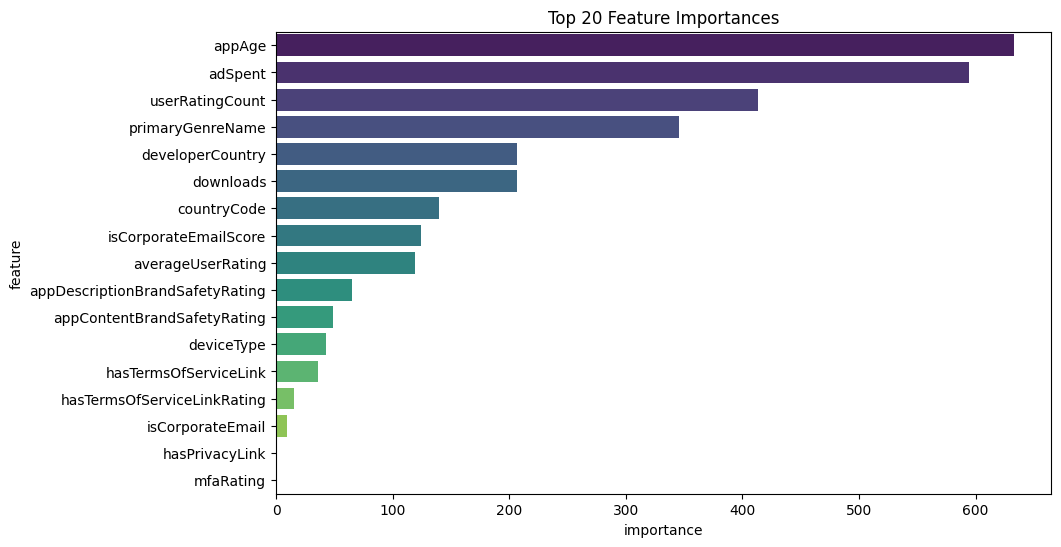

In [353]:
top_feat = plot_importances(lgbc)

In [354]:
test_pred, test_prob = pred(lgbc)

False    2875
True      125
Name: count, dtype: int64


## XGBoost Classifier

In [355]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [356]:
train_auc(xgbc)

AUC Score: 0.8738
Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.97      0.95      1261
        True       0.51      0.25      0.34       139

    accuracy                           0.90      1400
   macro avg       0.71      0.61      0.64      1400
weighted avg       0.88      0.90      0.89      1400



In [357]:
train_fold(xgbc)

CV SCORES: [0.85720765 0.88686038 0.87014988 0.87433463 0.86118481]
Mean CV Score: 0.8699474686996911
Std Deviation: 0.010434766941590698


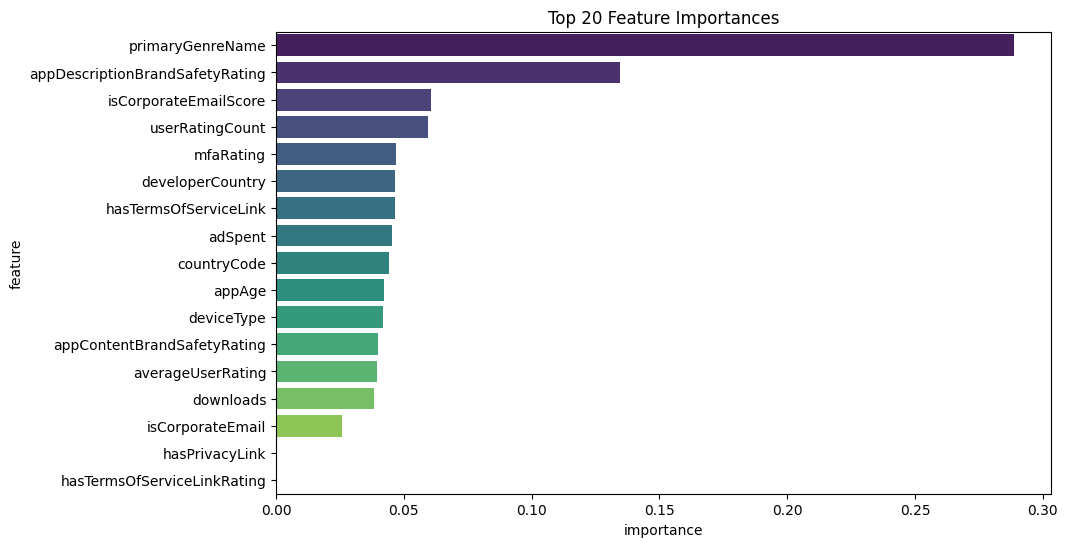

In [358]:
top_feat = plot_importances(xgbc)

In [359]:
test_pred, test_prob = pred(xgbc)

False    2832
True      168
Name: count, dtype: int64


## Catboost Classifier
- **UNUSED**
- Lower AUC Score compared to XGB & LGB

In [360]:
# cbc = CatBoostClassifier(verbose=False)
# cbc.fit(X_train, y_train)

In [361]:
# train_auc(cbc)

In [362]:
# train_fold(cbc)

In [363]:
# top_feat = plot_importances(cbc)

In [364]:
# test_pred, test_prob = pred(cbc)

# Model Tuning / Hyperparameter Optimization

## LGBM Tuning

In [365]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10)
    }

    model = LGBMClassifier(**params, verbose=-1)
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)

    return auc

In [366]:
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=100, show_progress_bar=True)

print("Best AUC:", study_lgb.best_value)
print("Best params:", study_lgb.best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

Best AUC: 0.8996970544103972
Best params: {'n_estimators': 137, 'learning_rate': 0.05600319935538883, 'num_leaves': 30, 'max_depth': 3, 'subsample': 0.7226572939489394, 'colsample_bytree': 0.6343501954631736, 'reg_alpha': 8.987666365684127, 'reg_lambda': 0.21637544912308046, 'min_child_samples': 96, 'scale_pos_weight': 7.578851931258302}


In [367]:
best_model_lgb = LGBMClassifier(**study_lgb.best_params, verbose=-1)
best_model_lgb.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.6343501954631736,
               learning_rate=0.05600319935538883, max_depth=3,
               min_child_samples=96, n_estimators=137, num_leaves=30,
               reg_alpha=8.987666365684127, reg_lambda=0.21637544912308046,
               scale_pos_weight=7.578851931258302, subsample=0.7226572939489394,
               verbose=-1)

## Tuned LGBM Evaluation

In [368]:
train_auc(best_model_lgb)

AUC Score: 0.8997
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.77      0.86      1261
        True       0.30      0.90      0.45       139

    accuracy                           0.78      1400
   macro avg       0.64      0.83      0.65      1400
weighted avg       0.92      0.78      0.82      1400



In [369]:
train_fold(best_model_lgb)

CV SCORES: [0.88191683 0.9019449  0.88783026 0.87305667 0.88621032]
Mean CV Score: 0.8861917950628735
Std Deviation: 0.00939842591224229


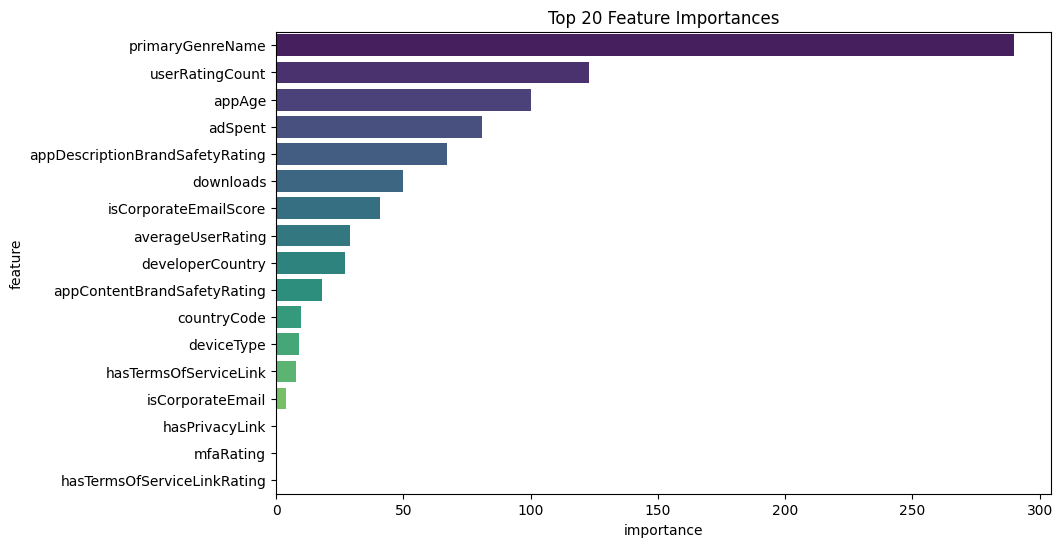

In [370]:
top_feat_lgb = plot_importances(best_model_lgb)

In [371]:
test_pred, test_prob = pred(best_model_lgb)

False    2046
True      954
Name: count, dtype: int64


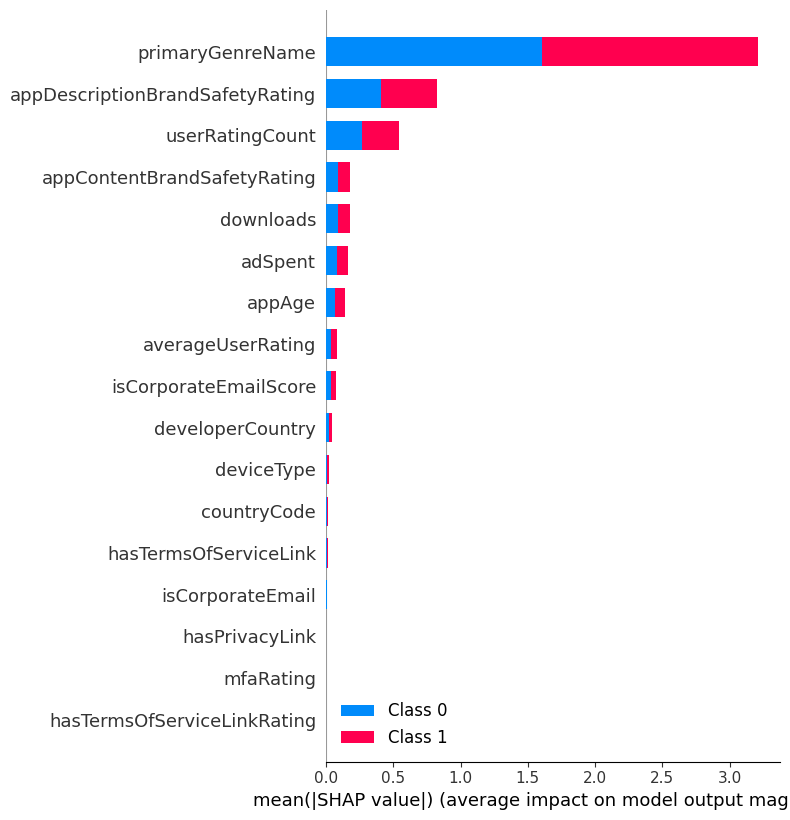

In [372]:
X_obs = pd.DataFrame(X_val, columns=train.columns)

explainer = shap.TreeExplainer(best_model_lgb)
shap_values = explainer.shap_values(X_obs)

shap.summary_plot(shap_values, X_obs)

## XGboost Tuning

In [373]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10), 
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)

    return auc

In [374]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100, show_progress_bar=True)

print("Best AUC:", study_xgb.best_value)
print("Best params:", study_xgb.best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

Best AUC: 0.9032685033575043
Best params: {'n_estimators': 146, 'max_depth': 11, 'learning_rate': 0.278251028083876, 'subsample': 0.9765595036297892, 'colsample_bytree': 0.5280293157916026, 'gamma': 4.777527123640553, 'reg_alpha': 3.6570309793755147, 'reg_lambda': 5.63888477605297, 'scale_pos_weight': 7.042710085218523}


In [375]:
best_model_xgb = XGBClassifier(**study_xgb.best_params, verbose=-1)
best_model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5280293157916026, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=4.777527123640553,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.278251028083876,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=146, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Tuned XGBoost Evaluation

In [376]:
train_auc(best_model_xgb)

AUC Score: 0.9033
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.80      0.88      1261
        True       0.33      0.89      0.48       139

    accuracy                           0.81      1400
   macro avg       0.66      0.85      0.68      1400
weighted avg       0.92      0.81      0.84      1400



In [377]:
train_fold(best_model_xgb)

CV SCORES: [0.87631433 0.89437982 0.89054878 0.87354446 0.88492347]
Mean CV Score: 0.8839421730963964
Std Deviation: 0.007998136692794743


In [378]:
test_pred, test_prob = pred(best_model_xgb)

False    2161
True      839
Name: count, dtype: int64


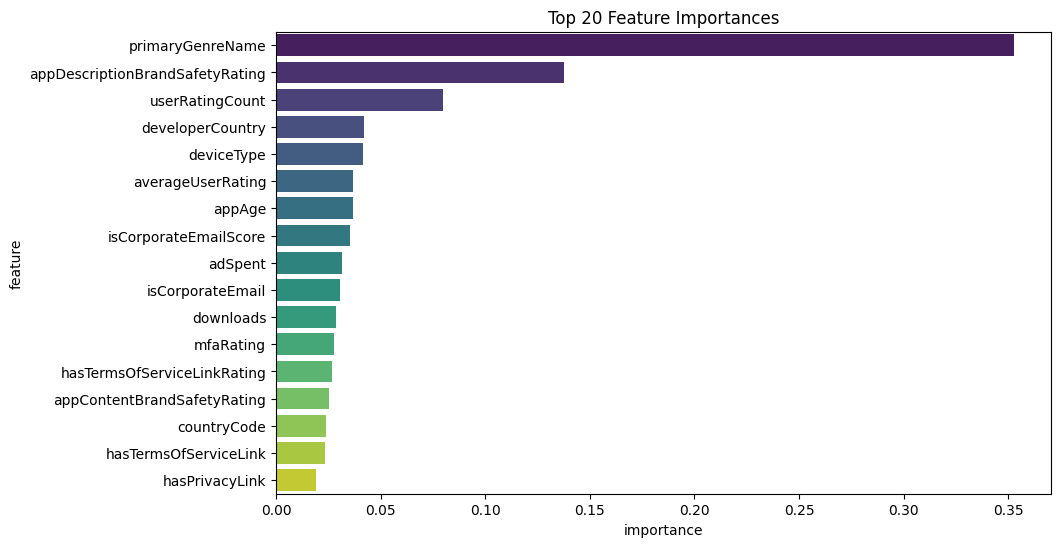

In [379]:
top_feat_xgb = plot_importances(best_model_xgb)

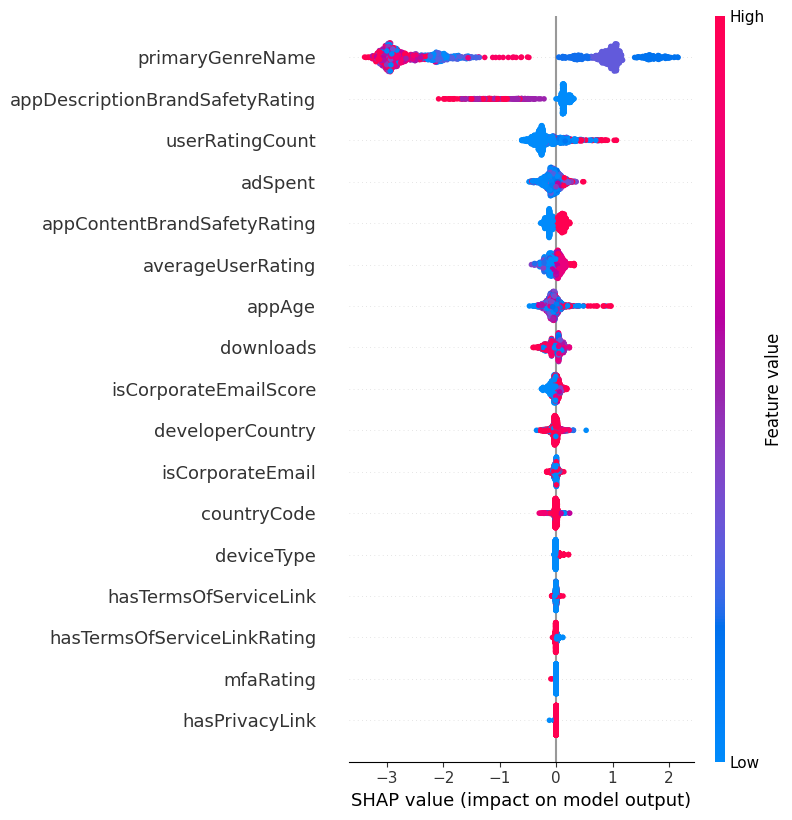

In [380]:
X_obs = pd.DataFrame(X_val, columns=train.columns)

explainer = shap.TreeExplainer(best_model_xgb)
shap_values = explainer.shap_values(X_obs)

shap.summary_plot(shap_values, X_obs)

## Catboost Tuning

In [381]:
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# def objective_cat(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
#         'random_strength': trial.suggest_float('random_strength', 1e-9, 10),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
#         'eval_metric': 'AUC',
#         'loss_function': 'Logloss',
#         'verbose': 0,
#         'random_state': 42,
#         'task_type': 'CPU'
#     }

#     model = CatBoostClassifier(**params)
#     model.fit(X_train, y_train)

#     y_pred_proba = model.predict_proba(X_val)[:, 1]
#     auc = roc_auc_score(y_val, y_pred_proba)

#     # print(f"[Trial {trial.number}] AUC: {auc:.4f} with {params}")
#     return auc

In [382]:
# study_cat = optuna.create_study(direction='maximize')
# study_cat.optimize(objective_cat, n_trials=100, show_progress_bar=True)

# print("\nBest trial:")
# print(f"  Score: {study_cat.best_value:.4f}")
# print(f"  Params: {study_cat.best_params}")

In [383]:
# best_model_cat = CatBoostClassifier(**study_cat.best_params, verbose=False)
# best_model_cat.fit(X_train, y_train)

## Tuned Catboost Evaluation

In [384]:
# train_auc(best_model_cat)

In [385]:
# train_fold(best_model_cat)

In [386]:
# top_feat_cat = plot_importances(best_model_cat)

In [387]:
# test_pred, test_prob = pred(best_model_cat)

In [388]:
# X_obs = pd.DataFrame(X_val, columns=train.columns)

# explainer = shap.TreeExplainer(best_model_cat)
# shap_values = explainer.shap_values(X_obs)

# shap.summary_plot(shap_values, X_obs)

# Model Deployment

## Train Best Model (LGBM)

In [389]:
best_model = LGBMClassifier(**study_lgb.best_params, verbose=-1)
best_model.fit(train_main, label)

LGBMClassifier(colsample_bytree=0.6343501954631736,
               learning_rate=0.05600319935538883, max_depth=3,
               min_child_samples=96, n_estimators=137, num_leaves=30,
               reg_alpha=8.987666365684127, reg_lambda=0.21637544912308046,
               scale_pos_weight=7.578851931258302, subsample=0.7226572939489394,
               verbose=-1)

## Predict Test with Best Model

In [390]:
test_prob = best_model.predict_proba(test)[:, 1]
threshold = 0.5
test_pred = test_prob > threshold  

test_pred = pd.Series(test_pred)
test_prob = pd.Series(test_prob)

print(test_pred.value_counts())

False    2045
True      955
Name: count, dtype: int64


## Submission

In [391]:
test_prob = pd.Series(test_prob)

test_prob.name = 'coppaRisk'
submission = submission_format.merge(test_prob, left_index=True, right_index=True)

In [392]:
submission = submission.drop(columns=['coppaRisk_x']).rename(columns={'coppaRisk_y': 'coppaRisk'})

In [393]:
submission.head(10)

,ID,coppaRisk
0,2807,0.082844
1,1742,0.577118
2,806,0.800301
3,2635,0.202567
4,9047,0.045813
5,3048,0.008531
6,4691,0.867877
7,1346,0.703512
8,7045,0.008503
9,958,0.760162


In [394]:
submission.to_csv('SUBMISSION.csv', index=False)

## Import Model

In [395]:
with open('lgbmc.pkl','wb') as f:
    pickle.dump(best_model,f)